# Setup

## Libraries

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from textblob import TextBlob
from langdetect import detect
import time
import geopandas as gpd
import osmnx as ox
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from scipy import spatial
from shapely import wkt
import altair as alt
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

## Display preferences

In [99]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [100]:
# pd.reset_option('display.max_colwidth')
# pd.set_option('display.max_colwidth', None)

## Functions

In [101]:
def equal_columns(df):
    equal_columns = []
    columns = df.columns

    for i, col1 in enumerate(columns):
        for j in range(i + 1, len(columns)):
            col2 = columns[j]
            if (df[col1] == df[col2]).all():
                equal_columns.append((col1, col2))
    return equal_columns

def one_value_columns(df):
    one_value_cols = df.nunique()[df.nunique() == 1].index
    return one_value_cols

def fill_na(df):
    col = df.columns
    for x in col:
        if df[x].isnull().sum()>0:
            if df[df[x]==0][x].count()==0:
                df[x].fillna(0, inplace=True)
                print("fill nulls with 0 for:", x)
            else:
                df[x].fillna(df[x].median(), inplace=True)
                print("fill nulls with median for:", x)

def remove_html_tags(text):
    if isinstance(text, str):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)
    else:
        return text

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

def onehot_df(df, variable, unique_items):
    item_lists = df[variable]
    for i, label in enumerate(unique_items):
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    del df[variable]
    return df

def unique_values_col(df):
    cols = df.columns
    print('columns having unique values for each row:')
    for x in cols:
        if len(df[x].unique())==df.shape[0]:
            print(x)

# Import the data

In [102]:
pd.set_option('display.max_colwidth', None)

In [103]:
df_listing = pd.read_csv('data/listings.csv.gz', encoding='utf-8')

print(df_listing.shape)
df_listing.head(1)

(75241, 75)


id                                      listing_url  \
0  714569379355913481  https://www.airbnb.com/rooms/714569379355913481   

        scrape_id last_scraped       source  \
0  20230314070633   2023-03-14  city scrape   

                                      name  \
0  Lovely private bedroom in Muswell Hill.   

                                       description neighborhood_overview  \
0  Take a break and unwind at this peaceful oasis.                   NaN   

                                                                                                           picture_url  \
0  https://a0.muscache.com/pictures/miso/Hosting-714569379355913481/original/6bf97b29-01cb-4978-9799-3dcb00d489ba.jpeg   

    host_id                                    host_url host_name  host_since  \
0  39009854  https://www.airbnb.com/users/show/39009854   Forough  2015-07-20   

            host_location host_about host_response_time host_response_rate  \
0  London, United Kingdom        NaN                NaN                NaN   

  host_acceptance_rate host_is_superhost  \
0                  NaN                 f   

                                                                                           host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/403a9e06-3a8d-4461-b913-2c13c058ad3b.jpg?aki_policy=profile_small   

                                                                                                host_picture_url  \
0  https://a0.muscache.com/im/pictures/user/403a9e06-3a8d-4461-b913-2c13c058ad3b.jpg?aki_policy=profile_x_medium   

  host_neighbourhood  host_listings_count  host_total_listings_count  \
0                NaN                  1.0                        1.0   

   host_verifications host_has_profile_pic host_identity_verified  \
0  ['email', 'phone']                    t                      f   

  neighbourhood neighbourhood_cleansed  neighbourhood_group_cleansed  \
0           NaN               Haringey                           NaN   

   latitude  longitude          property_type     room_type  accommodates  \
0  51.59728   -0.13933  Private room in condo  Private room             1   

   bathrooms bathrooms_text  bedrooms  beds  \
0        NaN  1 shared bath       1.0   1.0   

                                                                             amenities  \
0  ["Iron", "Hangers", "Hair dryer", "Outdoor dining area", "Hot water", "Essentials"]   

     price  minimum_nights  maximum_nights  minimum_minimum_nights  \
0  $100.00               1             365                     1.0   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                     1.0                   365.0                   365.0   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
0                     1.0                   365.0               NaN   

  has_availability  availability_30  availability_60  availability_90  \
0                t               30               60               90   

   availability_365 calendar_last_scraped  number_of_reviews  \
0               365            2023-03-14                  0   

   number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  \
0                      0                       0          NaN         NaN   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                   NaN                     NaN                        NaN   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                    NaN                          NaN                     NaN   

   review_scores_value  license instant_bookable  \
0                  NaN      NaN                f   

   calculated_host_listings_count  \
0                               1   

   calculated_host_listings_count_entire_homes  \
0                                            0   

   calculated_host_listings_count_private_rooms  \
0                                

# Clean the data

In [104]:
df_listing['price'].isnull().sum()

0

## Remove columns that have all null values

In [105]:
all_nulls_cols = df_listing.columns[df_listing.isnull().all()].tolist()

all_nulls_cols

['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license']

In [106]:
df_listing = df_listing.dropna(how='all', axis=1)
df_listing.shape

(75241, 71)

## Format price to numerical values

In [107]:
df_listing['price'].head()

0    $100.00
1     $65.00
2    $132.00
3    $100.00
4    $120.00
Name: price, dtype: object

In [108]:
df_listing['price'] = df_listing['price'].str[1:-3]
df_listing['price'] = df_listing['price'].str.replace(",", "")
df_listing['price'] = df_listing['price'].astype(float)

In [109]:
df_listing['price'].head()

0    100.0
1     65.0
2    132.0
3    100.0
4    120.0
Name: price, dtype: float64

## Keep only the rows with positive prices

In [110]:
df_listing['price'].describe().round(2)

count    75241.00
mean       175.73
std        487.36
min          0.00
25%         60.00
50%        100.00
75%        180.00
max      70111.00
Name: price, dtype: float64

In [111]:
(df_listing['price']==0).sum()

14

In [112]:
df_listing = df_listing[df_listing['price']>0]

df_listing.shape

(75227, 71)

## Keep only the listings that have received one or more reviews in the last 12 months

`number_of_reviews_ltm`: The number of reviews the listing has (in the last 12 months)

In [113]:
df_listing = df_listing[df_listing['number_of_reviews_ltm']>0]

df_listing.shape

(36636, 71)

In [114]:
df_listing.room_type.value_counts()

Entire home/apt    23668
Private room       12695
Shared room          149
Hotel room           124
Name: room_type, dtype: int64

## Remove some columns

### Remove variables with unique values for each row

In [115]:
unique_values_col(df_listing)

columns having unique values for each row:
id
listing_url


In [116]:
df_listing['listing_url'].describe()

count                                               36636
unique                                              36636
top       https://www.airbnb.com/rooms/825491308329325404
freq                                                    1
Name: listing_url, dtype: object

In [117]:
df_listing[['id']].head()

id
5   825491308329325404
6   786791705194673775
9   749834503531737273
12  717113207077160928
16            50584271

`id`: Airbnb's unique identifier for the listing

In [118]:
df_listing['id'].dtype

dtype('int64')

### Remove columns with only one value

In [119]:
one_value_columns(df_listing)

Index(['scrape_id'], dtype='object')

In [120]:
df_listing['scrape_id'].value_counts()

20230314070633    36636
Name: scrape_id, dtype: int64

### Scraped date columns

In [121]:
df_listing['last_scraped'].value_counts()

2023-03-14    18457
2023-03-15    14714
2023-03-16     3429
2023-03-29       36
Name: last_scraped, dtype: int64

In [122]:
df_listing['calendar_last_scraped'].value_counts()

2023-03-14    18460
2023-03-15    14715
2023-03-16     3425
2023-03-29       36
Name: calendar_last_scraped, dtype: int64

In [123]:
df_listing.drop(columns=['scrape_id','last_scraped','calendar_last_scraped'], inplace=True)

df_listing.set_index('id', inplace=True)

In [124]:
print(df_listing.shape)
df_listing.head(1)

(36636, 67)


listing_url  \
id                                                                    
825491308329325404  https://www.airbnb.com/rooms/825491308329325404   

                         source                         name    description  \
id                                                                            
825491308329325404  city scrape  Cosy room with own bathroom  Spacious room   

                   neighborhood_overview  \
id                                         
825491308329325404                   NaN   

                                                                                                                            picture_url  \
id                                                                                                                                        
825491308329325404  https://a0.muscache.com/pictures/miso/Hosting-825491308329325404/original/34a08427-59a4-4907-8029-2a449ede7f44.jpeg   

                      host_id                                     host_url  \
id                                                                           
825491308329325404  500808473  https://www.airbnb.com/users/show/500808473   

                    host_name  host_since host_location host_about  \
id                                                                   
825491308329325404  Ekaterina  2023-02-12           NaN        NaN   

                   host_response_time host_response_rate host_acceptance_rate  \
id                                                                              
825491308329325404     within an hour               100%                 100%   

                   host_is_superhost  \
id                                     
825491308329325404                 f   

                                                         host_thumbnail_url  \
id                                                                            
825491308329325404  https://a0.muscache.com/defaults/user_pic-50x50.png?v=3   

                                                             host_picture_url  \
id                                                                              
825491308329325404  https://a0.muscache.com/defaults/user_pic-225x225.png?v=3   

                   host_neighbourhood  host_listings_count  \
id                                                           
825491308329325404                NaN                  1.0   

                    host_total_listings_count  host_verifications  \
id                                                                  
825491308329325404                        1.0  ['email', 'phone']   

                   host_has_profile_pic host_identity_verified neighbourhood  \
id                                                                             
825491308329325404                    f                      f           NaN   

                   neighbourhood_cleansed   latitude  longitude  \
id                                                                
825491308329325404                 Merton  51.416047  -0.174299   

                                  property_type     room_type  accommodates  \
id                                                                            
825491308329325404  Private room in rental unit  Private room             2   

                    bathrooms_text  bedrooms  beds  \
id                                                   
825491308329325404  1 private bath       1.0   1.0   

                                                                                                                                                    amenities  \
id                                                                                                                                                              
825491308329325404  ["Washer", "First aid kit", "Fire extinguisher", "Smoke alarm", "Kitchen", "TV", "Carbon monoxide alarm", "Lock on bedroom door", "Wifi"]   

                    price  minimum_ni

## Convert percentages from strings (98%) to numbers (0.98)

In [125]:
df_listing[['host_response_rate','host_acceptance_rate']].head()

host_response_rate host_acceptance_rate
id                                                        
825491308329325404               100%                 100%
786791705194673775                98%                  87%
749834503531737273               100%                 100%
717113207077160928               100%                 100%
50584271                         100%                  93%

In [126]:
df_listing[['host_response_rate','host_acceptance_rate']].describe()

host_response_rate host_acceptance_rate
count               33120                36231
unique                 75                   98
top                  100%                 100%
freq                24379                11821

In [127]:
df_listing[['host_response_rate']].value_counts()

host_response_rate
100%                  24379
90%                    1213
98%                    1062
99%                    1058
97%                     599
80%                     423
96%                     418
94%                     297
95%                     289
92%                     272
91%                     268
0%                      236
93%                     226
86%                     223
50%                     211
67%                     184
75%                     174
88%                     163
70%                     161
89%                     153
83%                     135
60%                     113
79%                     106
85%                      76
87%                      61
33%                      52
63%                      47
81%                      45
82%                      44
78%                      44
43%                      32
71%                      31
65%                      29
77%                      27
40%                      23
5

In [128]:
df_listing[['host_acceptance_rate']].value_counts()

host_acceptance_rate
100%                    11821
99%                      3350
98%                      1822
97%                      1576
96%                      1034
94%                       905
93%                       899
95%                       809
92%                       618
91%                       603
89%                       601
86%                       579
88%                       570
90%                       563
83%                       501
50%                       500
67%                       496
80%                       494
75%                       465
87%                       399
71%                       362
85%                       341
82%                       328
84%                       305
78%                       287
60%                       274
73%                       259
79%                       243
77%                       239
81%                       218
70%                       211
76%                       210
47%                

In [129]:
df_listing[['host_acceptance_rate','host_response_rate']].dtypes

host_acceptance_rate    object
host_response_rate      object
dtype: object

In [130]:
df_listing['host_response_rate'] = df_listing['host_response_rate'].apply(
    lambda x: int(x[:len(x)-1])/100 if isinstance(x,str) else x)
df_listing['host_acceptance_rate'] = df_listing['host_acceptance_rate'].apply(
    lambda x: int(x[:len(x)-1])/100 if isinstance(x,str) else x)

In [131]:
df_listing[['host_response_rate','host_acceptance_rate']].head()

host_response_rate  host_acceptance_rate
id                                                          
825491308329325404                1.00                  1.00
786791705194673775                0.98                  0.87
749834503531737273                1.00                  1.00
717113207077160928                1.00                  1.00
50584271                          1.00                  0.93

In [132]:
df_listing[['host_acceptance_rate','host_response_rate']].dtypes

host_acceptance_rate    float64
host_response_rate      float64
dtype: object

In [133]:
df_listing[['host_acceptance_rate','host_response_rate']].describe()

host_acceptance_rate  host_response_rate
count          36231.000000        33120.000000
mean               0.879268            0.960954
std                0.177950            0.121629
min                0.000000            0.000000
25%                0.830000            0.990000
50%                0.970000            1.000000
75%                1.000000            1.000000
max                1.000000            1.000000

In [134]:
df_listing[['host_acceptance_rate']].value_counts()

host_acceptance_rate
1.00                    11821
0.99                     3350
0.98                     1822
0.97                     1576
0.96                     1034
0.94                      905
0.93                      899
0.95                      809
0.92                      618
0.91                      603
0.89                      601
0.86                      579
0.88                      570
0.90                      563
0.83                      501
0.50                      500
0.67                      496
0.80                      494
0.75                      465
0.87                      399
0.71                      362
0.85                      341
0.82                      328
0.84                      305
0.78                      287
0.60                      274
0.73                      259
0.79                      243
0.77                      239
0.81                      218
0.70                      211
0.76                      210
0.47               

In [135]:
df_listing[['host_response_rate']].value_counts()

host_response_rate
1.00                  24379
0.90                   1213
0.98                   1062
0.99                   1058
0.97                    599
0.80                    423
0.96                    418
0.94                    297
0.95                    289
0.92                    272
0.91                    268
0.00                    236
0.93                    226
0.86                    223
0.50                    211
0.67                    184
0.75                    174
0.88                    163
0.70                    161
0.89                    153
0.83                    135
0.60                    113
0.79                    106
0.85                     76
0.87                     61
0.33                     52
0.63                     47
0.81                     45
0.82                     44
0.78                     44
0.43                     32
0.71                     31
0.65                     29
0.77                     27
0.40                     23
0

## Convert 'bathrooms_text' to numbers ('bathrooms')

In [136]:
df_listing['bathrooms_text'].unique()

array(['1 private bath', '1 bath', '1 shared bath', '2 shared baths',
       '2 baths', '1.5 shared baths', '1.5 baths', '2.5 baths',
       '3 shared baths', '3 baths', '6.5 baths', '3.5 baths', '4.5 baths',
       'Half-bath', '4 baths', '5.5 baths', '2.5 shared baths',
       '3.5 shared baths', '5 baths', '4.5 shared baths', nan, '0 baths',
       '0 shared baths', '10.5 baths', 'Private half-bath',
       'Shared half-bath', '7.5 baths', '4 shared baths', '10 baths',
       '6 baths', '8.5 baths', '12.5 baths', '8 baths',
       '5.5 shared baths', '9 baths', '12 baths', '7 shared baths',
       '5 shared baths', '8.5 shared baths', '8 shared baths'],
      dtype=object)

In [137]:
df_listing['bathrooms_text'] = df_listing['bathrooms_text'].str.lower()

df_listing['bathrooms'] = df_listing['bathrooms_text'].str.extract('(\\d+\\.\\d+)').astype(float).fillna(
    df_listing['bathrooms_text'].str.extract('(\\d+)').astype(float))
df_listing['bathrooms'] = df_listing['bathrooms'].fillna('none')
df_listing.loc[df_listing['bathrooms_text'].str.contains('half-bath',na=False).fillna(False),'bathrooms']=0.5

df_listing['bathrooms'] = df_listing['bathrooms'].replace('none', np.nan)
df_listing['bathrooms'] = df_listing['bathrooms'].astype(float)

In [138]:
df_listing[['bathrooms_text', 'bathrooms']].tail()

bathrooms_text  bathrooms
id                                           
18762362                    1 bath        1.0
3191081                  1.5 baths        1.5
654949753111689538          1 bath        1.0
827653589245352551         2 baths        2.0
599135204165144789  1 private bath        1.0

In [139]:
df_listing[['bathrooms_text', 'bathrooms']].dtypes

bathrooms_text     object
bathrooms         float64
dtype: object

In [140]:
print(df_listing[['bathrooms_text', 'bathrooms']].isnull().sum())
print("")
print(df_listing['bathrooms_text'].str.contains('half-bath').sum())
print((df_listing['bathrooms']==0.5).sum())

bathrooms_text    32
bathrooms         32
dtype: int64

35
35


In [141]:
df_listing[['bathrooms']].describe()

bathrooms
count  36604.000000
mean       1.332204
std        0.605210
min        0.000000
25%        1.000000
50%        1.000000
75%        1.500000
max       12.500000

In [142]:
df_listing[['bathrooms_text']].describe()

bathrooms_text
count           36604
unique             39
top            1 bath
freq            15678

In [143]:
df_listing[['bathrooms_text']].value_counts()

bathrooms_text   
1 bath               15678
1 shared bath         5330
2 baths               4271
1 private bath        3228
1.5 baths             3117
1.5 shared baths      1730
2.5 baths             1061
2 shared baths         652
3 baths                584
3.5 baths              271
2.5 shared baths       223
3 shared baths         105
4 baths                 85
4.5 baths               56
0 shared baths          48
3.5 shared baths        27
0 baths                 23
5 baths                 22
shared half-bath        19
5.5 baths               13
4.5 shared baths        10
half-bath               10
6.5 baths                7
6 baths                  6
private half-bath        6
7.5 baths                4
5.5 shared baths         3
5 shared baths           2
7 shared baths           2
12.5 baths               2
10 baths                 1
4 shared baths           1
12 baths                 1
8 baths                  1
8 shared baths           1
8.5 baths                1
8.5 shared

In [144]:
df_listing[['bathrooms']].value_counts()

bathrooms
1.0          24236
2.0           4923
1.5           4847
2.5           1284
3.0            689
3.5            298
4.0             86
0.0             71
4.5             66
0.5             35
5.0             24
5.5             16
6.5              7
6.0              6
7.5              4
7.0              2
8.0              2
8.5              2
12.5             2
9.0              1
10.0             1
10.5             1
12.0             1
dtype: int64

## Extract bathroom sharing information ('bathroom_sharing')

In [145]:
df_listing['bathroom_sharing'] = df_listing['bathrooms_text'].str.extract(pat=r"(shared|private)")
df_listing['bathroom_sharing'].fillna('unknown',inplace=True)

In [146]:
df_listing[['bathrooms_text','bathroom_sharing']].head()

bathrooms_text bathroom_sharing
id                                                 
825491308329325404  1 private bath          private
786791705194673775          1 bath          unknown
749834503531737273   1 shared bath           shared
717113207077160928  1 private bath          private
50584271             1 shared bath           shared

In [147]:
df_listing.drop(['bathrooms_text'],axis=1,inplace=True)

In [148]:
df_listing[['bathroom_sharing']].value_counts()

bathroom_sharing
unknown             25248
shared               8154
private              3234
dtype: int64

In [149]:
df_listing[['bathroom_sharing']].describe()

bathroom_sharing
count             36636
unique                3
top             unknown
freq              25248

## Number of amenities ('amenities_count')

### Some EDA

In [150]:
df_listing.price.describe()

count    36636.000000
mean       170.575035
std        301.044558
min         10.000000
25%         70.000000
50%        120.000000
75%        195.000000
max      35243.000000
Name: price, dtype: float64

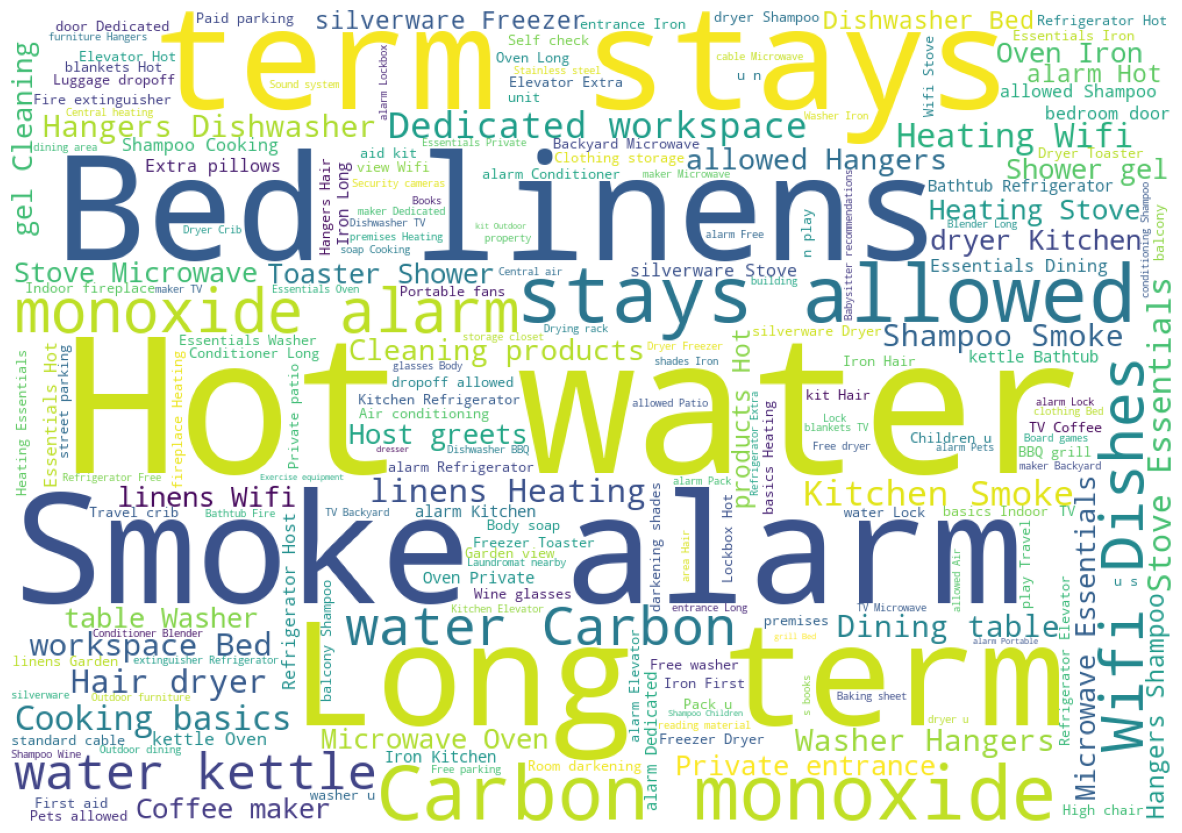

In [151]:
# Create a dataframe of the words that appear in the ammenities 
# of the most expensive listings

df = df_listing.copy()
df.reset_index(inplace=True)
df = df[df['room_type'] != 'Hotel room']

df2 = df[['amenities','price','id']]
df2_sort = df2.sort_values('price',ascending=[0]).head(300)

all_amenities = ''
for index,row in df2_sort.iterrows():
    p = re.sub('[^a-zA-Z]+',' ', row['amenities'])
    all_amenities += p
    
all_data = nltk.word_tokenize(all_amenities)
filtered_data = [word for word in all_data if word not in stopwords.words('english')]

wnl = nltk.WordNetLemmatizer() 
filtered_data = [wnl.lemmatize(data) for data in filtered_data]
all_words = ' '.join(all_data)

wordcloud = WordCloud(width=1000,height=700,
                      background_color="white").generate(all_words)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
# plt.title("Amenities in the 300 most expensive listings")
plt.show()

In [152]:
print(len(all_data), len(filtered_data))

14769 13967


In [153]:
pd.reset_option('display.max_colwidth')

In [154]:
df_listing['amenities'].head()

id
825491308329325404    ["Washer", "First aid kit", "Fire extinguisher...
786791705194673775                          ["Washer", "TV", "Kitchen"]
749834503531737273    ["Washer", "Smoke alarm", "Free parking on pre...
717113207077160928                          ["Outdoor furniture", "TV"]
50584271              ["Washer", "Outdoor furniture", "Hangers", "Di...
Name: amenities, dtype: object

In [155]:
pd.set_option('display.max_colwidth', None)

In [156]:
df_listing[['amenities']].describe()

amenities
count                                                                         36636
unique                                                                        34691
top     ["Washer", "Kitchen", "Smoke alarm", "TV", "Carbon monoxide alarm", "Wifi"]
freq                                                                             32

In [157]:
df_listing['amenities'] = df_listing['amenities'].str.lower()

df_listing['amenities'] = df_listing['amenities'].apply(lambda x: ast.literal_eval(x))

In [158]:
df_listing[['amenities']].head()

amenities
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
825491308329325404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [washer, first aid kit, fire extinguisher, smoke alarm, kitchen, tv, carbon monoxide alarm, lock on bedroom door, wifi]
786791705194673775                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [washer, tv, kitchen]
749834503531737273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [washer, smoke alarm, free parking on premises, tv, carbon monoxide alarm, dedicated workspace, wifi]
717113207077160928                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [159]:
df_listing['amenities_count'] = df_listing['amenities'].apply(lambda x: len(x))

In [160]:
df_listing[['amenities','amenities_count']].head()

amenities  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
825491308329325404                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [washer, first aid kit, fire extinguisher, smoke alarm, kitchen, tv, carbon monoxide alarm, lock on bedroom door, wifi]   
786791705194673775                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [washer, tv, kitchen]   
749834503531737273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [washer, smoke alarm, free parking on premises, tv, carbon monoxide alarm, dedicated workspace, wifi]   
717113207077160928                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [161]:
pd.reset_option('display.max_colwidth')

In [162]:
df_listing[['amenities_count']].describe()

amenities_count
count     36636.000000
mean         30.927585
std          13.802258
min           0.000000
25%          21.000000
50%          30.000000
75%          41.000000
max         116.000000

In [163]:
df_listing['amenities_count'].dtypes

dtype('int64')

In [164]:
df_listing[['amenities_count']].value_counts()

amenities_count
30                 1029
31                 1024
29                 1010
28                  985
23                  958
27                  954
25                  943
35                  925
32                  922
33                  921
34                  920
37                  918
24                  917
26                  899
36                  880
38                  838
22                  828
40                  828
20                  798
18                  793
39                  777
21                  767
19                  753
42                  753
43                  733
15                  710
16                  703
44                  701
17                  690
41                  665
14                  630
45                  613
13                  610
46                  606
47                  582
12                  557
48                  522
11                  497
50                  490
49                  490
10                  470


In [165]:
df_listing[df_listing['amenities_count'] == 1][['amenities','amenities_count']].reset_index()

id                       amenities  amenities_count
0             51608135        [43" tv with chromecast]                1
1   740474249021667654                            [tv]                1
2             52766223           [outdoor dining area]                1
3   698320211133139190                          [wifi]                1
4             53685806           [dedicated workspace]                1
5              7818374               [host greets you]                1
6             49220161                    [hair dryer]                1
7   750886297774118819           [outdoor dining area]                1
8   601329086873991029             [hdtv with netflix]                1
9   673724680404874583                          [wifi]                1
10  661999159551971791           [outdoor dining area]                1
11  687174945383147582           [outdoor dining area]                1
12  671541147824618631           [outdoor dining area]                1
13  660670418063038971                  [pets allowed]                1
14  760295062535553880  [security cameras on property]                1
15  729121332137835132  [security cameras on property]                1
16  739877146863131831                  [pets allowed]                1
17  745376274682020151              [indoor fireplace]                1
18  749031025240730684                            [tv]                1
19  665131760036624192  [security cameras on property]                1
20  604770509090121846                  [pets allowed]                1
21  707242364858131724                       [hot tub]                1
22            52775071                   [smoke alarm]                1
23  684718969537405000               [smoking allowed]                1
24  605514037517783975           [dedicated workspace]                1
25  656283745508240330  [security cameras on property]                1
26  716678466469713952                            [tv]                1

In [166]:
df_listing[df_listing['amenities_count'] == 0][['amenities','amenities_count']].reset_index()

id amenities  amenities_count
0   652766550152485461        []                0
1   671512213931470232        []                0
2   642794290907111335        []                0
3   761351106606727311        []                0
4             48106199        []                0
5   753427335752719967        []                0
6             17419730        []                0
7   726512039518643734        []                0
8   760301161696580691        []                0
9   750824239020917451        []                0
10  738975588348282808        []                0
11  654148444340170150        []                0
12  759665280590350595        []                0
13  610894725132843216        []                0
14  660194756589540452        []                0
15  715782956639977624        []                0
16  753432220062611422        []                0
17  706460754636686043        []                0
18             2164284        []                0
19             1091148        []                0
20            54343226        []                0
21  738855975702655075        []                0

## Description length

In [167]:
df_listing['description'].head()

id
825491308329325404                                        Spacious room
786791705194673775    This unique place has a style all its own. Tak...
749834503531737273    Get comfortable and enjoy plenty of extra room...
717113207077160928                Relax at this peaceful place to stay.
50584271                     This unique place has a style all its own.
Name: description, dtype: object

In [168]:
df_listing['description'] = df_listing['description'].apply(remove_html_tags)

df_listing['description_length'] = df_listing['description'].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df_listing['description_length'] = df_listing['description_length'].replace(0, np.nan)

In [169]:
df_listing['description_length'].head()

id
825491308329325404     2.0
786791705194673775    16.0
749834503531737273    12.0
717113207077160928     7.0
50584271               9.0
Name: description_length, dtype: float64

In [170]:
df_listing[['description_length']].describe()

description_length
count        36264.000000
mean           116.755929
std             48.560808
min              1.000000
25%             78.000000
50%            137.000000
75%            158.000000
max            203.000000

In [171]:
df_listing['description_length'].dtypes

dtype('float64')

In [172]:
df_listing[['description_length']].value_counts()

description_length
158.0                 756
160.0                 703
159.0                 699
161.0                 686
157.0                 676
162.0                 664
155.0                 643
164.0                 615
156.0                 611
163.0                 607
154.0                 600
153.0                 592
165.0                 587
151.0                 570
166.0                 530
150.0                 514
152.0                 510
167.0                 496
149.0                 432
148.0                 417
168.0                 407
146.0                 396
169.0                 381
147.0                 366
170.0                 360
145.0                 352
9.0                   319
171.0                 318
84.0                  316
81.0                  316
144.0                 314
78.0                  310
82.0                  310
80.0                  306
83.0                  300
79.0                  296
172.0                 285
86.0               

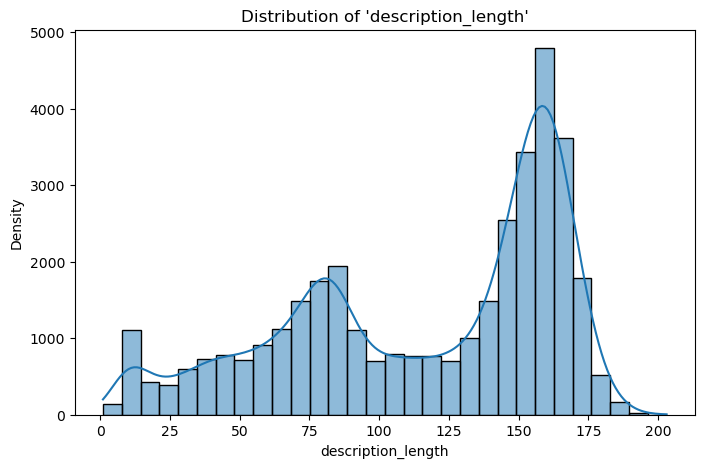

In [173]:
plt.figure(figsize=(8,5))
sns.histplot(df_listing['description_length'], bins=30, kde=True)
plt.title("Distribution of 'description_length'")
plt.xlabel('description_length')
plt.ylabel('Density')
plt.show()

## Replace 'f' and 't' with 0 and 1

In [174]:
cols_with_f_t = [col for col in df_listing.columns if df_listing[col].isin(['f', 't']).any()]

cols_with_f_t

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'has_availability',
 'instant_bookable']

In [175]:
df_listing[cols_with_f_t].head()

host_is_superhost host_has_profile_pic  \
id                                                          
825491308329325404                 f                    f   
786791705194673775                 f                    f   
749834503531737273                 f                    t   
717113207077160928                 t                    t   
50584271                           t                    t   

                   host_identity_verified has_availability instant_bookable  
id                                                                           
825491308329325404                      f                t                f  
786791705194673775                      t                t                f  
749834503531737273                      t                t                f  
717113207077160928                      t                t                t  
50584271                                t                t                f

In [176]:
# cols_to_replace = ['host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable']
# df_listing[cols_to_replace].head()

In [177]:
for col in cols_with_f_t:
    df_listing[col] = df_listing[col].map({'f': 0, 't': 1})

In [178]:
df_listing[cols_with_f_t].head()

host_is_superhost  host_has_profile_pic  \
id                                                            
825491308329325404                0.0                     0   
786791705194673775                0.0                     0   
749834503531737273                0.0                     1   
717113207077160928                1.0                     1   
50584271                          1.0                     1   

                    host_identity_verified  has_availability  instant_bookable  
id                                                                              
825491308329325404                       0                 1                 0  
786791705194673775                       1                 1                 0  
749834503531737273                       1                 1                 0  
717113207077160928                       1                 1                 1  
50584271                                 1                 1                 0

In [179]:
df_listing[cols_with_f_t].dtypes

host_is_superhost         float64
host_has_profile_pic        int64
host_identity_verified      int64
has_availability            int64
instant_bookable            int64
dtype: object

In [180]:
df_listing[cols_with_f_t].isnull().sum()

host_is_superhost         1
host_has_profile_pic      0
host_identity_verified    0
has_availability          0
instant_bookable          0
dtype: int64

In [181]:
df_listing[cols_with_f_t].nunique()

host_is_superhost         2
host_has_profile_pic      2
host_identity_verified    2
has_availability          2
instant_bookable          2
dtype: int64

In [182]:
from IPython.display import display

for col in cols_with_f_t:
    print(f"\nValue counts for '{col}':")
    display(df_listing[col].value_counts(dropna=False).to_frame())


Value counts for 'host_is_superhost':


host_is_superhost
0.0              27263
1.0               9372
NaN                  1


Value counts for 'host_has_profile_pic':


host_has_profile_pic
1                 35767
0                   869


Value counts for 'host_identity_verified':


host_identity_verified
1                   34322
0                    2314


Value counts for 'has_availability':


has_availability
1             36590
0                46


Value counts for 'instant_bookable':


instant_bookable
0             25224
1             11412

In [183]:
# df_listing[cols_to_replace] = df_listing[cols_to_replace].replace({'f':0,'t':1})
# df_listing[cols_to_replace].head()

## Date columns

In [184]:
print(df_listing[['host_since','first_review','last_review']].isnull().sum())
print("")
df_listing[['host_since']].head()

host_since      0
first_review    0
last_review     0
dtype: int64



host_since
id                            
825491308329325404  2023-02-12
786791705194673775  2022-12-09
749834503531737273  2021-06-17
717113207077160928  2015-11-09
50584271            2015-02-13

In [185]:
df_listing[['host_since','first_review','last_review']].describe()

host_since first_review last_review
count        36636        36636       36636
unique        4274         3553         372
top     2011-11-22   2023-01-02  2023-03-12
freq           170          218        1405

In [186]:
columns = ['host_since','first_review','last_review']

for col in columns:
    print(f"Latest date for '{col}': {df_listing[col].max()}")

Latest date for 'host_since': 2023-03-10
Latest date for 'first_review': 2023-03-14
Latest date for 'last_review': 2023-03-26


In [187]:
df_listing[columns].dtypes

host_since      object
first_review    object
last_review     object
dtype: object

In [188]:
df_listing['host_duration'] = (pd.to_datetime('2023-03-29')-pd.to_datetime(df_listing['host_since'])).dt.days
df_listing['day_since_first_review'] = (pd.to_datetime('2023-03-29')-pd.to_datetime(df_listing['first_review'])).dt.days
df_listing['day_since_last_review'] = (pd.to_datetime('2023-03-29')-pd.to_datetime(df_listing['last_review'])).dt.days

In [189]:
df_listing[[
    'day_since_last_review','last_review','day_since_first_review','first_review','host_duration','host_since'
]].head()

day_since_last_review last_review  day_since_first_review  \
id                                                                              
825491308329325404                     16  2023-03-13                      38   
786791705194673775                     20  2023-03-09                      61   
749834503531737273                     88  2022-12-31                     104   
717113207077160928                    122  2022-11-27                     182   
50584271                              122  2022-11-27                     566   

                   first_review  host_duration  host_since  
id                                                          
825491308329325404   2023-02-19             45  2023-02-12  
786791705194673775   2023-01-27            110  2022-12-09  
749834503531737273   2022-12-15            650  2021-06-17  
717113207077160928   2022-09-28           2697  2015-11-09  
50584271             2021-09-09           2966  2015-02-13

In [190]:
df_listing.host_since.describe()

count          36636
unique          4274
top       2011-11-22
freq             170
Name: host_since, dtype: object

### Some EDA

In [191]:
df_listing.sample()

listing_url       source  \
id                                                             
17811032  https://www.airbnb.com/rooms/17811032  city scrape   

                                                     name  \
id                                                          
17811032  En-suite room, easy access into London  and LHR   

                                                description  \
id                                                            
17811032  The North Wing is a large, airy, self-containe...   

                                      neighborhood_overview  \
id                                                            
17811032  We are located on a quiet, family street with ...   

                                                picture_url   host_id  \
id                                                                      
17811032  https://a0.muscache.com/pictures/2af49d6e-c3ab...  14999901   

                                            host_url host_name  host_since  \
id                                                                           
17811032  https://www.airbnb.com/users/show/14999901   Deborah  2014-05-02   

                   host_location  \
id                                 
17811032  London, United Kingdom   

                                                 host_about  \
id                                                            
17811032  I enjoy meeting people from all around the wor...   

         host_response_time  host_response_rate  host_acceptance_rate  \
id                                                                      
17811032       within a day                 1.0                  0.82   

          host_is_superhost  \
id                            
17811032                0.0   

                                         host_thumbnail_url  \
id                                                            
17811032  https://a0.muscache.com/im/pictures/user/0ddc4...   

                                           host_picture_url  \
id                                                            
17811032  https://a0.muscache.com/im/pictures/user/0ddc4...   

         host_neighbourhood  host_listings_count  host_total_listings_count  \
id                                                                            
17811032              Acton                  1.0                        1.0   

          host_verifications  host_has_profile_pic  host_identity_verified  \
id                                                                           
17811032  ['email', 'phone']                     1                       1   

                            neighbourhood neighbourhood_cleansed  latitude  \
id                                                                           
17811032  London, England, United Kingdom                 Ealing   51.5101   

          longitude         property_type     room_type  accommodates  \
id                                                                      
17811032   -0.27548  Private room in home  Private room             3   

          bedrooms  beds                                          amenities  \
id                                                                            
17811032       1.0   1.0  [hangers, private living room, bed linens, wif...   

          price  minimum_nights  maximum_nights  minimum_minimum_nights  \
id                                                                        
17811032   68.0               1               2                     1.0   

          maximum_minimum_nights  minimum_maximum_nights  \
id                                                         
17811032                     1.0                     2.0   

          maximum_maximum_nights  minimum_nights_avg_ntm  \
id                                                         
17811032                     2.0                     1.0   

          maximum_nights_avg_ntm  has_availability  availability_30  \
id    

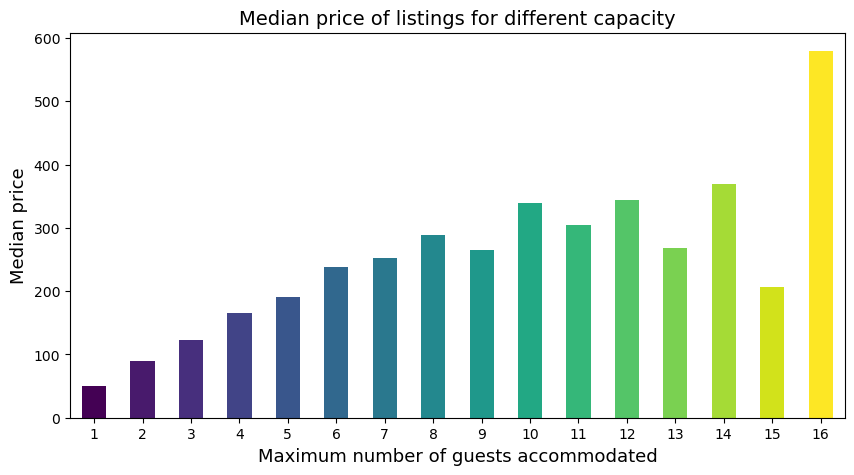

In [192]:
df = df_listing.copy()
df.reset_index(inplace=True)
df = df[df['room_type'] != 'Hotel room']

# Set up the color map
colors = plt.cm.viridis(np.linspace(0, 1, len(df['accommodates'].unique())))

plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar', color=colors)
plt.title('Median price of listings for different capacity', fontsize=14)
plt.xlabel('Maximum number of guests accommodated', fontsize=13)
plt.ylabel('Median price', fontsize=13)
plt.xticks(rotation=0)
plt.show()

In [193]:
df.groupby('accommodates').price.median()

accommodates
1      50.0
2      90.0
3     123.0
4     165.0
5     191.0
6     238.0
7     252.0
8     288.0
9     265.5
10    339.0
11    305.0
12    344.5
13    268.5
14    370.0
15    206.5
16    579.5
Name: price, dtype: float64

In [194]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

In [195]:
df_listing.drop(['host_since','first_review','last_review'],axis=1,inplace=True)
df_listing.shape

(36636, 70)

In [196]:
columns = ['host_duration', 'day_since_first_review', 'day_since_last_review']

df_listing[columns].describe().round(0).astype(int)

host_duration  day_since_first_review  day_since_last_review
count          36636                   36636                  36636
mean            2248                     880                     96
std             1168                     930                     83
min               19                      15                      3
25%             1363                     185                     30
50%             2447                     395                     70
75%             3128                    1451                    139
max             5229                    4846                    380

In [197]:
print(df_listing[columns].dtypes)

host_duration             int64
day_since_first_review    int64
day_since_last_review     int64
dtype: object


## Create dummy for some nulls (eg. 'name_missing')

To get the most information out of nulls I made a dummy for some nulls in order to check if there was a pattern in it. For example, if the description of a property was missing I believe that it may have some impact on price.

In [198]:
nulls = df_listing.isnull().sum()
nulls = nulls[nulls!=0]
nulls

name                              10
description                      372
neighborhood_overview          14342
host_location                   7953
host_about                     16002
host_response_time              3516
host_response_rate              3516
host_acceptance_rate             405
host_is_superhost                  1
host_neighbourhood             16795
neighbourhood                  14342
bedrooms                        1776
beds                             467
review_scores_accuracy             1
review_scores_cleanliness          3
review_scores_checkin              1
review_scores_communication        2
review_scores_location             1
review_scores_value                1
bathrooms                         32
description_length               372
dtype: int64

In [199]:
df_listing[['host_about']].head()

host_about
id                                                                   
825491308329325404                                                NaN
786791705194673775                                                NaN
749834503531737273  Hello everyone,\n\nMy name is Marta. And, I am...
717113207077160928  2No. Double bedrooms in very quiet area with s...
50584271            I was a freelance events organiser for many ye...

In [200]:
cols_to_check = [
    'name','description','neighborhood_overview','host_location','host_about','host_acceptance_rate','host_neighbourhood',
    'bedrooms','beds','bathrooms'
]

df_listing = df_listing.join(df_listing[cols_to_check].isnull().astype(int),rsuffix='_missing')

new_cols = [col + '_missing' for col in cols_to_check]

In [201]:
for col in new_cols:
    print(f"\nValue counts for '{col}':")
    display(df_listing[col].value_counts().to_frame())


Value counts for 'name_missing':


name_missing
0         36626
1            10


Value counts for 'description_missing':


description_missing
0                36264
1                  372


Value counts for 'neighborhood_overview_missing':


neighborhood_overview_missing
0                          22294
1                          14342


Value counts for 'host_location_missing':


host_location_missing
0                  28683
1                   7953


Value counts for 'host_about_missing':


host_about_missing
0               20634
1               16002


Value counts for 'host_acceptance_rate_missing':


host_acceptance_rate_missing
0                         36231
1                           405


Value counts for 'host_neighbourhood_missing':


host_neighbourhood_missing
0                       19841
1                       16795


Value counts for 'bedrooms_missing':


bedrooms_missing
0             34860
1              1776


Value counts for 'beds_missing':


beds_missing
0         36169
1           467


Value counts for 'bathrooms_missing':


bathrooms_missing
0              36604
1                 32

In [202]:
df_listing[cols_to_check].describe()

host_acceptance_rate      bedrooms          beds     bathrooms
count          36231.000000  34860.000000  36169.000000  36604.000000
mean               0.879268      1.525760      1.844369      1.332204
std                0.177950      0.886933      1.274993      0.605210
min                0.000000      1.000000      1.000000      0.000000
25%                0.830000      1.000000      1.000000      1.000000
50%                0.970000      1.000000      1.000000      1.000000
75%                1.000000      2.000000      2.000000      1.500000
max                1.000000     22.000000     24.000000     12.500000

In [203]:
categorical_cols = df_listing[cols_to_check].select_dtypes(include=['object']).columns

df_listing[categorical_cols].describe()

name  \
count                                  36626   
unique                                 35793   
top     Stunning Studio Near Hampstead Heath   
freq                                      19   

                                              description  \
count                                               36264   
unique                                              34057   
top     Enjoy a stylish experience at this centrally-l...   
freq                                                   89   

                                    neighborhood_overview  \
count                                               22294   
unique                                              18164   
top     Located in the heart of Primrose Hill in Centr...   
freq                                                   37   

                 host_location  \
count                    28683   
unique                     683   
top     London, United Kingdom   
freq                     20781   

                                               host_about host_neighbourhood  
count                                               20634              19841  
unique                                              10766                441  
top     City Relay is a property management company th...          Bayswater  
freq                                                  167                534

In [204]:
df_listing.shape

(36636, 80)

## Remove categorical non-explanatory columns

In [205]:
# first, make a copy for some columns that might be useful later
amenities_df = df_listing[['listing_url','amenities']].copy()
host_id_df = df_listing[['host_id']].copy()

In [206]:
amenities_df.head()

listing_url  \
id                                                                    
825491308329325404  https://www.airbnb.com/rooms/825491308329325404   
786791705194673775  https://www.airbnb.com/rooms/786791705194673775   
749834503531737273  https://www.airbnb.com/rooms/749834503531737273   
717113207077160928  https://www.airbnb.com/rooms/717113207077160928   
50584271                      https://www.airbnb.com/rooms/50584271   

                                                            amenities  
id                                                                     
825491308329325404  [washer, first aid kit, fire extinguisher, smo...  
786791705194673775                              [washer, tv, kitchen]  
749834503531737273  [washer, smoke alarm, free parking on premises...  
717113207077160928                            [outdoor furniture, tv]  
50584271            [washer, outdoor furniture, hangers, dishwashe...

In [207]:
host_id_df.head()

host_id
id                           
825491308329325404  500808473
786791705194673775  490795350
749834503531737273  407681693
717113207077160928   48602573
50584271             27697324

In [208]:
df_listing.select_dtypes(include='object').describe()

listing_url       source  \
count                                             36636        36636   
unique                                            36636            2   
top     https://www.airbnb.com/rooms/825491308329325404  city scrape   
freq                                                  1        31701   

                                        name  \
count                                  36626   
unique                                 35793   
top     Stunning Studio Near Hampstead Heath   
freq                                      19   

                                              description  \
count                                               36264   
unique                                              34057   
top     Enjoy a stylish experience at this centrally-l...   
freq                                                   89   

                                    neighborhood_overview  \
count                                               22294   
unique                                              18164   
top     Located in the heart of Primrose Hill in Centr...   
freq                                                   37   

                                              picture_url  \
count                                               36636   
unique                                              35703   
top     https://a0.muscache.com/pictures/0b32da45-5c2c...   
freq                                                   19   

                                         host_url host_name  \
count                                       36636     36636   
unique                                      21138      7776   
top     https://www.airbnb.com/users/show/1432477     David   
freq                                          167       308   

                 host_location  \
count                    28683   
unique                     683   
top     London, United Kingdom   
freq                     20781   

                                               host_about host_response_time  \
count                                               20634              33120   
unique                                              10766                  4   
top     City Relay is a property management company th...     within an hour   
freq                                                  167              22709   

                                       host_thumbnail_url  \
count                                               36636   
unique                                              20515   
top     https://a0.muscache.com/defaults/user_pic-50x5...   
freq                                                  869   

                                         host_picture_url host_neighbourhood  \
count                                               36636              19841   
unique                                              20515                441   
top     https://a0.muscache.com/defaults/user_pic-225x...          Bayswater   
freq                                                  869                534   

        host_verifications                            neighbourhood  \
count                36636                                    22294   
unique                   8                                      573   
top     ['email', 'phone']  Greater London, England, United Kingdom   
freq                 28414                                    16215   

       neighbourhood_cleansed       property_type        room_type  \
count                   36636               36636            36636   
unique                     33                  81                4   
top               Westminster  Entire rental unit  Entire home/apt   
freq                     4499               11252            23668   

                                                amenities bathroom_sharing  
count                                               36636            36636  
unique                                              34691           

In [209]:
df_listing.drop(columns=[
    'listing_url','source','name','description','neighborhood_overview','picture_url','host_url',
    'host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood',
    'host_verifications','neighbourhood','amenities'],inplace=True)

df_listing.shape

(36636, 64)

## Handle missing data

### Get dummies

In [210]:
df_listing.select_dtypes(include='object').describe()

host_response_time neighbourhood_cleansed       property_type  \
count               33120                  36636               36636   
unique                  4                     33                  81   
top        within an hour            Westminster  Entire rental unit   
freq                22709                   4499               11252   

              room_type bathroom_sharing  
count             36636            36636  
unique                4                3  
top     Entire home/apt          unknown  
freq              23668            25248

In [211]:
df_listing['host_response_time'].value_counts()

within an hour        22709
within a few hours     6200
within a day           3763
a few days or more      448
Name: host_response_time, dtype: int64

#### Make some maps first

In [212]:
df_counts = df_listing[['neighbourhood_cleansed']].value_counts().reset_index()
df_counts = df_counts.rename(columns={0:'number_of_listings','neighbourhood_cleansed':'borough'})
df_counts['rank'] = df_counts.index + 1
df_counts.set_index('borough', inplace=True)

print("\nNumber of active listings (reviews since March 2022) by London borough:")
df_counts


Number of active listings (reviews since March 2022) by London borough:


number_of_listings  rank
borough                                         
Westminster                           4499     1
Camden                                2715     2
Kensington and Chelsea                2699     3
Tower Hamlets                         2691     4
Hackney                               2309     5
Southwark                             1996     6
Lambeth                               1914     7
Islington                             1798     8
Wandsworth                            1716     9
Hammersmith and Fulham                1663    10
Brent                                 1209    11
Lewisham                               986    12
Newham                                 926    13
Ealing                                 900    14
Haringey                               886    15
Greenwich                              860    16
Barnet                                 843    17
Waltham Forest                         645    18
Croydon                                639    19
Hounslow                               585    20
Merton                                 568    21
Richmond upon Thames                   551    22
Hillingdon                             413    23
Enfield                                340    24
Bromley                                336    25
Redbridge                              332    26
Kingston upon Thames                   299    27
City of London                         270    28
Barking and Dagenham                   251    29
Harrow                                 242    30
Bexley                                 211    31
Havering                               181    32
Sutton                                 163    33

In [213]:
map_df = gpd.read_file('data/neighbourhoods.geojson')

# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df_listing.groupby('neighbourhood_cleansed').size())
borough_df.rename(columns={0:'number_of_listings'},inplace=True)
borough_df['median_price'] = df_listing.groupby('neighbourhood_cleansed').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

In [214]:
borough_map_df

geometry  \
neighbourhood                                                               
Kingston upon Thames    MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...   
Croydon                 MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...   
Bromley                 MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...   
Hounslow                MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...   
Ealing                  MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...   
Havering                MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...   
Hillingdon              MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...   
Harrow                  MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...   
Brent                   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...   
Barnet                  MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...   
Enfield                 MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...   
Waltham Forest          MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...   
Redbridge               MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...   
Sutton                  MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...   
Lambeth                 MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...   
Southwark               MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...   
Lewisham                MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...   
Greenwich               MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...   
Bexley                  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...   
Richmond upon Thames    MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...   
Merton                  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...   
Wandsworth              MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...   
Hammersmith and Fulham  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...   
Kensington and Chelsea  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...   
City of London          MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...   
Westminster             MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...   
Camden                  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...   
Tower Hamlets           MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...   
Islington               MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...   
Hackney                 MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...   
Haringey                MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...   
Newham                  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...   
Barking and Dagenham    MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...   

                        number_of_listings  median_price  
neighbourhood                                             
Kingston upon Thames                   299          84.0  
Croydon                                639          64.0  
Bromley                                336          78.5  
Hounslow                               585          92.0  
Ealing                                 900          85.0  
Havering                               181          76.0  
Hillingdon                             413          70.0  
Harrow                                 242          75.0  
Brent                                 1209          88.0  
Barnet                                 843          90.0  
Enfield                                340          70.0  
Waltham Forest                         645          85.0  
Redbridge                              332          65.0  
Sutton                                 163          68.0  
Lambeth                               1914         110.0  
Southwark                             1996         120.0  
Lewisham                               986          90.0  
Greenwich                              860          95.0  
Bexley                                 211          65.0  
Richmond upon Thames                   551         120.0  
Merton                                 568          90.0  
Wandsworth  

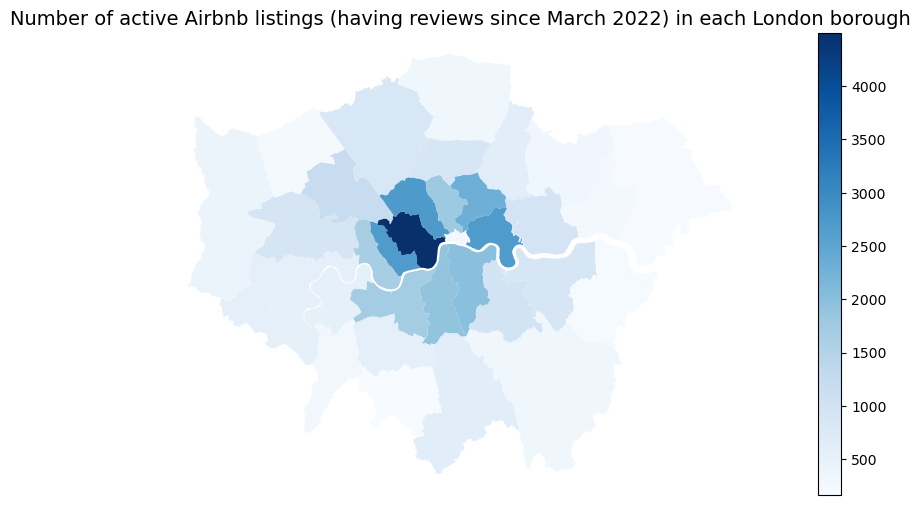

In [215]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of active Airbnb listings (having reviews since March 2022) in each London borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.number_of_listings), vmax=max(borough_map_df.number_of_listings)))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

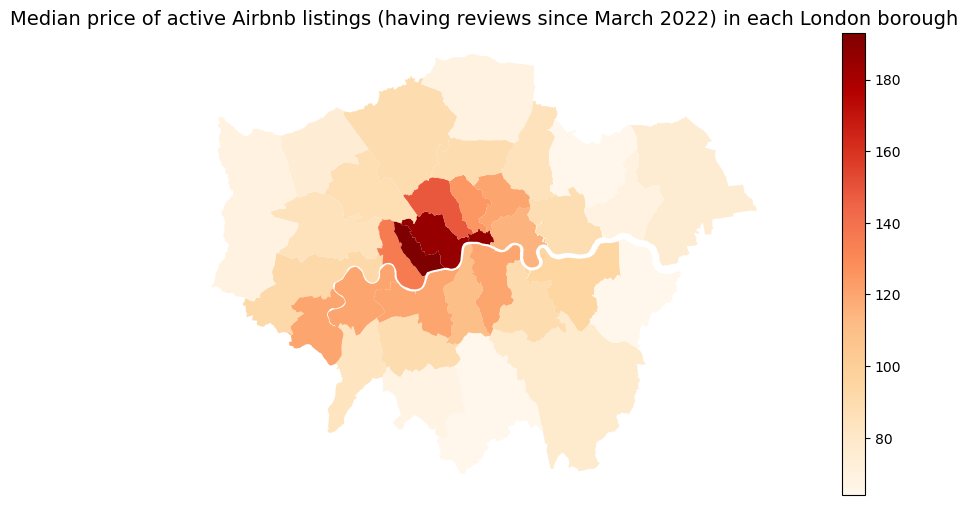

In [216]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='OrRd', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of active Airbnb listings (having reviews since March 2022) in each London borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [217]:
df_neighbourhood_prices = df_listing.groupby(
    by='neighbourhood_cleansed')['price'].median().sort_values(ascending=False).reset_index()

df_neighbourhood_prices = df_neighbourhood_prices.rename(columns={'price':'median_price','neighbourhood_cleansed':'borough'})
df_neighbourhood_prices['rank']=df_neighbourhood_prices.index+1
df_neighbourhood_prices.set_index("borough",inplace=True)

print("\nMedian price for active listings (reviews since March 2022) by London borough:\n")
df_neighbourhood_prices


Median price for active listings (reviews since March 2022) by London borough:



median_price  rank
borough                                   
Kensington and Chelsea         193.0     1
City of London                 186.5     2
Westminster                    185.0     3
Camden                         149.0     4
Hammersmith and Fulham         136.0     5
Islington                      125.0     6
Hackney                        120.0     7
Richmond upon Thames           120.0     8
Southwark                      120.0     9
Wandsworth                     120.0    10
Tower Hamlets                  115.0    11
Lambeth                        110.0    12
Greenwich                       95.0    13
Hounslow                        92.0    14
Barnet                          90.0    15
Lewisham                        90.0    16
Merton                          90.0    17
Haringey                        90.0    18
Newham                          88.5    19
Brent                           88.0    20
Waltham Forest                  85.0    21
Ealing                          85.0    22
Kingston upon Thames            84.0    23
Bromley                         78.5    24
Havering                        76.0    25
Harrow                          75.0    26
Barking and Dagenham            70.0    27
Enfield                         70.0    28
Hillingdon                      70.0    29
Sutton                          68.0    30
Redbridge                       65.0    31
Bexley                          65.0    32
Croydon                         64.0    33

#### Other visualisation

In [218]:
df_listing.room_type.value_counts()

Entire home/apt    23668
Private room       12695
Shared room          149
Hotel room           124
Name: room_type, dtype: int64

In [219]:
# group by room_type

df = df_listing.copy()
# df.reset_index()

room_type_group_count = pd.DataFrame(df.groupby("room_type").size().sort_values(ascending=False))
room_type_group_count = room_type_group_count.reset_index()
room_type_group_count.rename(columns={0:"number_of_listings"}, inplace=True)
room_type_group_count["percentage"]=round(room_type_group_count["number_of_listings"] / room_type_group_count["number_of_listings"].sum()*100, 1)
room_type_group_count

room_type  number_of_listings  percentage
0  Entire home/apt               23668        64.6
1     Private room               12695        34.7
2      Shared room                 149         0.4
3       Hotel room                 124         0.3

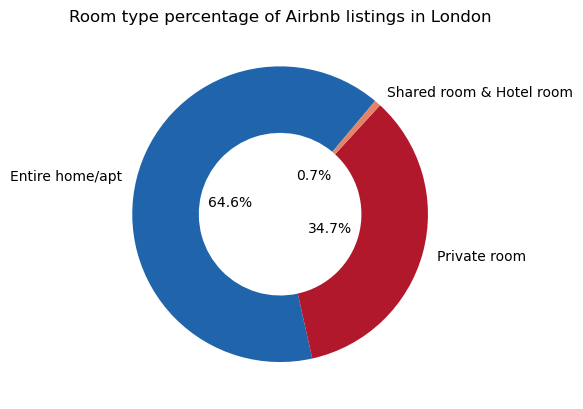

In [221]:
# draw a pie chart for room_type
cmap = matplotlib.cm.get_cmap('RdBu')

private_color = cmap(0.1)
entire_color = cmap(0.9)
shared_color = cmap(0.25)

fig1, ax1 = plt.subplots()
colors = [entire_color, private_color, shared_color]
data = [room_type_group_count.percentage[0], room_type_group_count.percentage[1],
        room_type_group_count.percentage[2] + room_type_group_count.percentage[3]]
labels = ['Entire home/apt', 'Private room', 'Shared room & Hotel room']
ax1.set_title("Room type percentage of Airbnb listings in London")

wedge, texts, autopct = ax1.pie(data, labels=labels, colors=colors,
                                startangle=50, wedgeprops={'width':0.45},
                                autopct='%1.1f%%', pctdistance=0.35)

In [222]:
# calculate the median price for each room type
median_prices = pd.DataFrame(df.groupby('room_type')['price'].median())
median_prices.reset_index(inplace=True)
median_prices.rename(columns={'price':'median_price'}, inplace=True)
median_prices = median_prices.sort_values(by='median_price', ascending=False)
median_prices = median_prices.reset_index(drop=True)
median_prices['rank']=median_prices.index+1
median_prices.set_index('room_type', inplace=True)

print("\nMedian price for each room type:")
median_prices


Median price for each room type:


median_price  rank
room_type                          
Hotel room              201.0     1
Entire home/apt         160.0     2
Private room             60.0     3
Shared room              39.0     4

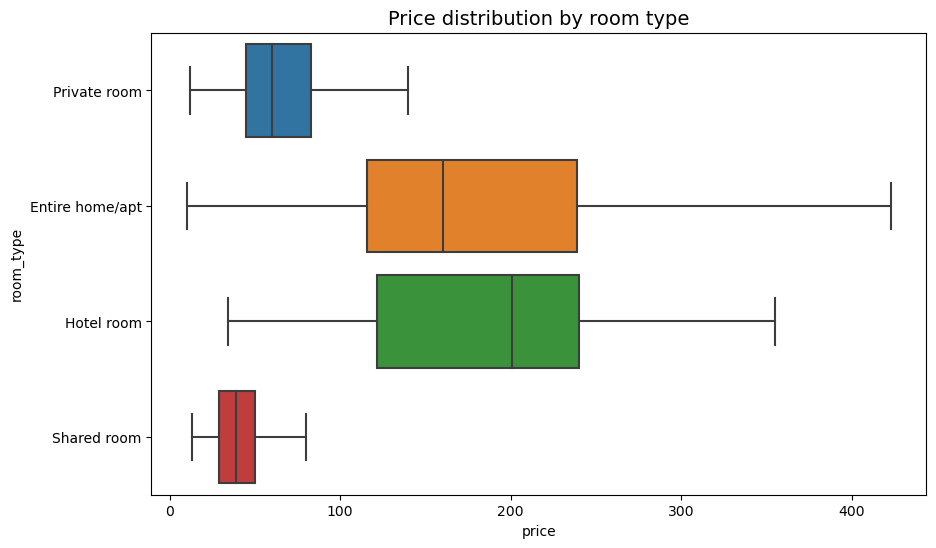

In [223]:
# plot the price distribution by room type

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="price", y="room_type", data=df, showfliers=False)
ax.set_title("Price distribution by room type", fontsize=14)

plt.show()

#### Outliers for price

In [122]:
Q1 = df.groupby('room_type')['price'].quantile(0.25)
Q3 = df.groupby('room_type')['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [123]:
upper_bound

room_type
Entire home/apt    423.50
Hotel room         417.75
Private room       140.00
Shared room         81.50
Name: price, dtype: float64

In [124]:
room_types = df['room_type'].unique()

outliers = []

for room_type in room_types:
    room_type_data = df[df['room_type'] == room_type]['price']
    Q1 = room_type_data.quantile(0.25)
    Q3 = room_type_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    room_type_outliers = room_type_data[(room_type_data < lower_bound) | (room_type_data > upper_bound)]
    outliers.append(room_type_outliers)

print("Outliers:")
outliers

Outliers:


[id
 659277912216774222     1570.0
 691086287141826813      180.0
 2211564                 150.0
 712142411914050883     1999.0
 49623105               1570.0
 664181905141002610      200.0
 729528088431361430      190.0
 49850231               1570.0
 44398509                192.0
 16197334                187.0
 602942848582152865      149.0
 44725409                275.0
 33097116                150.0
 2962765                 147.0
 11212346                160.0
 19516246                165.0
 43883480                173.0
 49481967                196.0
 715634934232562914      166.0
 736115066901198225      180.0
 49071748                238.0
 15664629                160.0
 50762524               1500.0
 731160849028772973      277.0
 45889628                242.0
 17844086                150.0
 53119792                145.0
 29582730                250.0
 680819136294483332      250.0
 714209874490123572      150.0
 822968363044733597      160.0
 40316425                560.0
 486

In [125]:
df.loc[[779761521836294353]]['room_type']

id
779761521836294353    Shared room
Name: room_type, dtype: object

#### Map of review scores by borough

In [126]:
# select columns related to review_scores
df.reset_index(inplace=True)

review_cols = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
               'review_scores_communication','review_scores_location','review_scores_value']
listing_detail_cols = ['id', 'neighbourhood_cleansed'] + review_cols

# Only keep the rows where all the review scores are present
res_df = df[df.filter(regex='review_scores').notnull().all(axis=1)]
res_df = res_df[listing_detail_cols].rename({'neighbourhood_cleansed':'neighbourhood'},axis=1)

In [127]:
res_df

id         neighbourhood  review_scores_rating  \
0      825491308329325404                Merton                  4.67   
1      786791705194673775               Croydon                  4.50   
2      749834503531737273               Enfield                  5.00   
3      717113207077160928                Barnet                  4.80   
4                50584271  Kingston upon Thames                  4.95   
...                   ...                   ...                   ...   
36631            18762362                 Brent                  3.80   
36632             3191081               Lambeth                  4.84   
36633  654949753111689538                 Brent                  4.52   
36634  827653589245352551             Islington                  5.00   
36635  599135204165144789           Westminster                  4.32   

       review_scores_accuracy  review_scores_cleanliness  \
0                        5.00                       4.67   
1                        4.83                       4.67   
2                        5.00                       4.50   
3                        5.00                       4.60   
4                        4.89                       4.84   
...                       ...                        ...   
36631                    4.00                       3.90   
36632                    4.95                       5.00   
36633                    4.78                       4.35   
36634                    5.00                       5.00   
36635                    4.68                       4.68   

       review_scores_checkin  review_scores_communication  \
0                       4.67                         5.00   
1                       5.00                         4.83   
2                       4.50                         5.00   
3                       5.00                         5.00   
4                       5.00                         4.95   
...                      ...                          ...   
36631                   4.40                         3.90   
36632                   5.00                         4.95   
36633                   4.96                         5.00   
36634                   5.00                         3.00   
36635                   4.16                         3.89   

       review_scores_location  review_scores_value  
0                        4.67                 4.67  
1                        4.83                 4.67  
2                        4.00                 4.50  
3                        4.80                 4.90  
4                        4.89                 4.89  
...                       ...                  ...  
36631                    4.40                 4.00  
36632                    4.84                 4.84  
36633                    4.70                 4.35  
36634                    5.00                 5.00  
36635                    4.63                 4.21  

[36632 rows x 9 columns]

In [128]:
map_df = gpd.read_file('data/neighbourhoods.geojson')

# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

map_df.shape

(33, 2)

In [129]:
# merge data and calculate the mean value of each review type
geo_rev = map_df.merge(res_df, how='inner', on='neighbourhood')

geo_rev['mean_review_scores_accuracy'] = geo_rev.groupby('neighbourhood')['review_scores_accuracy'].transform('mean')
geo_rev['mean_review_scores_cleanliness'] = geo_rev.groupby('neighbourhood')['review_scores_cleanliness'].transform('mean')
geo_rev['mean_review_scores_checkin'] = geo_rev.groupby('neighbourhood')['review_scores_checkin'].transform('mean')
geo_rev['mean_review_scores_communication'] = geo_rev.groupby('neighbourhood')['review_scores_communication'].transform('mean')
geo_rev['mean_review_scores_location'] = geo_rev.groupby('neighbourhood')['review_scores_location'].transform('mean')
geo_rev['mean_review_scores_value'] = geo_rev.groupby('neighbourhood')['review_scores_value'].transform('mean')
geo_rev['mean_review_scores_rating'] = geo_rev.groupby('neighbourhood')['review_scores_rating'].transform('mean')

In [130]:
geo_rev

neighbourhood  \
0      Kingston upon Thames   
1      Kingston upon Thames   
2      Kingston upon Thames   
3      Kingston upon Thames   
4      Kingston upon Thames   
...                     ...   
36627  Barking and Dagenham   
36628  Barking and Dagenham   
36629  Barking and Dagenham   
36630  Barking and Dagenham   
36631  Barking and Dagenham   

                                                geometry                  id  \
0      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...            50584271   
1      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  693310735906508902   
2      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  618368327106537907   
3      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...            28932566   
4      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...            15278535   
...                                                  ...                 ...   
36627  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...             4020479   
36628  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...            30285485   
36629  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...            46428593   
36630  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...  579360598037925162   
36631  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...  596915748121671918   

       review_scores_rating  review_scores_accuracy  \
0                      4.95                    4.89   
1                      4.73                    4.82   
2                      5.00                    5.00   
3                      4.92                    4.95   
4                      4.88                    4.92   
...                     ...                     ...   
36627                  5.00                    4.75   
36628                  4.82                    4.84   
36629                  5.00                    5.00   
36630                  4.78                    4.83   
36631                  4.89                    4.78   

       review_scores_cleanliness  review_scores_checkin  \
0                           4.84                   5.00   
1                           4.73                   4.64   
2                           5.00                   4.83   
3                           4.99                   4.93   
4                           4.96                   4.93   
...                          ...                    ...   
36627                       4.63                   4.63   
36628                       4.61                   4.84   
36629                       5.00                   4.86   
36630                       4.52                   4.91   
36631                       4.78                   4.78   

       review_scores_communication  review_scores_location  \
0                             4.95                    4.89   
1                             4.82                    4.82   
2                             5.00                    4.67   
3                             4.96                    4.76   
4                             4.97                    4.82   
...                            ...                     ...   
36627                         4.75                    4.13   
36628                         4.91                    4.59   
36629                         5.00                    4.86   
36630                         4.91                    4.43   
36631                         5.00                    4.33   

       review_scores_value  mean_review_scores_accuracy  \
0                     4.89                     4.815786   
1                     4.82                     4.815786   
2                     4.83                     4.815786   
3                     4.80                     4.815786   
4                     4.88                     4.815786   
...                    ...                          ...   
36627                 4.88                     4.688048   
36628                 4.77                     4.688048   
36629                 5.00        

In [131]:
# plot the average review scores by neighbourhood

review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin',
               'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value','mean_review_scores_rating'
              ]

review_titles = ['Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value', 'Rating']

review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = geo_rev[['geometry','neighbourhood'] + review_cols].drop_duplicates()

In [132]:
result_df

geometry  \
0      MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...   
299    MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...   
938    MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...   
1274   MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...   
1859   MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...   
2758   MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...   
2939   MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...   
3352   MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...   
3594   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...   
4803   MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...   
5646   MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...   
5986   MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...   
6631   MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...   
6963   MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...   
7126   MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...   
9039   MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...   
11034  MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...   
12020  MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...   
12880  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...   
13091  MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...   
13642  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...   
14210  MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...   
15926  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...   
17588  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...   
20287  MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...   
20557  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...   
25056  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...   
27771  MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...   
30462  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...   
32260  MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...   
34569  MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...   
35455  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...   
36381  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...   

                neighbourhood  mean_review_scores_accuracy  \
0        Kingston upon Thames                     4.815786   
299                   Croydon                     4.709327   
938                   Bromley                     4.773571   
1274                 Hounslow                     4.660855   
1859                   Ealing                     4.673782   
2758                 Havering                     4.739448   
2939               Hillingdon                     4.611162   
3352                   Harrow                     4.680289   
3594                    Brent                     4.679016   
4803                   Barnet                     4.697805   
5646                  Enfield                     4.674559   
5986           Waltham Forest                     4.775054   
6631                Redbridge                     4.673645   
6963                   Sutton                     4.747914   
7126                  Lambeth                     4.787559   
9039                Southwark                     4.741614   
11034                Lewisham                     4.778499   
12020               Greenwich                     4.720709   
12880                  Bexley                     4.734834   
13091    Richmond upon Thames                     4.850327   
13642                  Merton                     4.771496   
14210              Wandsworth                     4.786713   
15926  Hammersmith and Fulham                     4.726336   
17588  Kensington and Chelsea                     4.650611   
20287          City of London                     4.620704   
20557             Westminster                     4.632220   
25056                  Camden                     4.674041   
27771           Tower Hamlets                     4.686351   
30462               Islington                     4.728276   
32260                 Hackney                     4.786583   
34569                Haringey                     4.799300   
35455                  

In [133]:
def gen_map_chart(df, review_col, review_title):
    chart = alt.Chart(
        df,
        title=alt.TitleParams(review_title, fontSize=14)
    ).mark_geoshape(
        stroke='black',  # Outline the shapes
        strokeWidth=0.5
    ).encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=300,
        height=300
    )
    
    return chart

In [134]:
# Create the overall chart
overall_chart = gen_map_chart(result_df, 'mean_review_scores_rating', 'Rating')

# Create the rows and columns
rows = [alt.hconcat(overall_chart)]  # Add the overall chart to the first row only
current_row = []
for review_col, review_title in zip(review_cols[:-1], review_titles[:-1]):  # Exclude the last one, which is 'Overall'
    current_row.append(gen_map_chart(result_df, review_col, review_title))
    if len(current_row) == 3:
        rows.append(alt.hconcat(*current_row))
        current_row = []
if current_row:
    rows.append(alt.hconcat(*current_row))

# Create the final chart
final_chart = alt.vconcat(*rows,
              title='Average review scores by London borough', 
              center=True
).configure_view(strokeWidth=0
).configure_title(fontSize=18
).configure_legend(title=None, orient='top', labelFontSize=12)

final_chart

alt.VConcatChart(...)

In [135]:
result_df.sample()

geometry neighbourhood  \
30462  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...     Islington   

       mean_review_scores_accuracy  mean_review_scores_cleanliness  \
30462                     4.728276                        4.624388   

       mean_review_scores_checkin  mean_review_scores_communication  \
30462                    4.786207                          4.803899   

       mean_review_scores_location  mean_review_scores_value  \
30462                      4.77262                  4.589093   

       mean_review_scores_rating  
30462                   4.668354

In [136]:
# print the result in descending order of overall rating scores

rating_df = result_df.sort_values(by='mean_review_scores_rating', ascending=False)[['neighbourhood','mean_review_scores_rating']].reset_index(drop=True)
rating_df = rating_df.rename(columns={'neighbourhood':'borough'})
rating_df['rank'] = rating_df.index + 1
rating_df.set_index('borough',inplace=True)

print("\nAverage rating scores by London borough:")
rating_df


Average rating scores by London borough:


mean_review_scores_rating  rank
borough                                                
Richmond upon Thames                     4.821325     1
Kingston upon Thames                     4.770836     2
Bromley                                  4.761577     3
Haringey                                 4.758205     4
Wandsworth                               4.753182     5
Hackney                                  4.749086     6
Merton                                   4.746039     7
Lewisham                                 4.736410     8
Lambeth                                  4.736346     9
Waltham Forest                           4.720062    10
Havering                                 4.711215    11
Sutton                                   4.697423    12
Southwark                                4.691198    13
Croydon                                  4.679139    14
Greenwich                                4.678965    15
Bexley                                   4.675450    16
Hammersmith and Fulham                   4.670866    17
Islington                                4.668354    18
Barnet                                   4.665919    19
Enfield                                  4.654000    20
Barking and Dagenham                     4.647490    21
Newham                                   4.642613    22
Redbridge                                4.634578    23
Harrow                                   4.631405    24
Brent                                    4.629049    25
Tower Hamlets                            4.628372    26
Ealing                                   4.624305    27
Hounslow                                 4.620530    28
Kensington and Chelsea                   4.618033    29
Camden                                   4.603993    30
Westminster                              4.584766    31
Hillingdon                               4.546586    32
City of London                           4.544481    33

In [137]:
# print the result in descending order of location scores

loc_df = result_df.sort_values(by='mean_review_scores_location', ascending=False)[['neighbourhood','mean_review_scores_location']].reset_index(drop=True)
loc_df = loc_df.rename(columns={'neighbourhood':'borough'})
loc_df['rank'] = loc_df.index + 1
loc_df.set_index('borough',inplace=True)

print("\nAverage location scores by London borough:")
loc_df


Average location scores by London borough:


mean_review_scores_location  rank
borough                                                  
Richmond upon Thames                       4.862886     1
Kensington and Chelsea                     4.845398     2
City of London                             4.821037     3
Westminster                                4.820951     4
Camden                                     4.811772     5
Kingston upon Thames                       4.787458     6
Hackney                                    4.773608     7
Islington                                  4.772620     8
Wandsworth                                 4.752127     9
Hammersmith and Fulham                     4.747136    10
Lambeth                                    4.744281    11
Merton                                     4.744137    12
Southwark                                  4.724927    13
Bromley                                    4.701488    14
Sutton                                     4.701411    15
Haringey                                   4.693679    16
Tower Hamlets                              4.667384    17
Harrow                                     4.660083    18
Waltham Forest                             4.659938    19
Lewisham                                   4.656552    20
Barnet                                     4.644531    21
Havering                                   4.642155    22
Greenwich                                  4.640465    23
Hillingdon                                 4.634286    24
Bexley                                     4.624550    25
Hounslow                                   4.620342    26
Newham                                     4.611598    27
Ealing                                     4.610289    28
Brent                                      4.608536    29
Redbridge                                  4.563886    30
Croydon                                    4.555070    31
Enfield                                    4.554647    32
Barking and Dagenham                       4.512988    33

#### Are there any relationships between different types of guest review scores?

In [138]:
geo_rev[review_cols]

mean_review_scores_accuracy  mean_review_scores_cleanliness  \
0                         4.815786                        4.742776   
1                         4.815786                        4.742776   
2                         4.815786                        4.742776   
3                         4.815786                        4.742776   
4                         4.815786                        4.742776   
...                            ...                             ...   
36627                     4.688048                        4.648406   
36628                     4.688048                        4.648406   
36629                     4.688048                        4.648406   
36630                     4.688048                        4.648406   
36631                     4.688048                        4.648406   

       mean_review_scores_checkin  mean_review_scores_communication  \
0                        4.874247                          4.864247   
1                        4.874247                          4.864247   
2                        4.874247                          4.864247   
3                        4.874247                          4.864247   
4                        4.874247                          4.864247   
...                           ...                               ...   
36627                    4.740040                          4.800677   
36628                    4.740040                          4.800677   
36629                    4.740040                          4.800677   
36630                    4.740040                          4.800677   
36631                    4.740040                          4.800677   

       mean_review_scores_location  mean_review_scores_value  \
0                         4.787458                  4.693746   
1                         4.787458                  4.693746   
2                         4.787458                  4.693746   
3                         4.787458                  4.693746   
4                         4.787458                  4.693746   
...                            ...                       ...   
36627                     4.512988                  4.579243   
36628                     4.512988                  4.579243   
36629                     4.512988                  4.579243   
36630                     4.512988                  4.579243   
36631                     4.512988                  4.579243   

       mean_review_scores_rating  
0                       4.770836  
1                       4.770836  
2                       4.770836  
3                       4.770836  
4                       4.770836  
...                          ...  
36627                   4.647490  
36628                   4.647490  
36629                   4.647490  
36630                   4.647490  
36631                   4.647490  

[36632 rows x 7 columns]

In [139]:
result_df = (geo_rev[review_cols].rename(review_map, axis=1)
                                         .corr()
                                         .reset_index()
                                         .melt(id_vars='index')
                                         .rename({'value': 'correlation'}, axis=1))

In [140]:
base = alt.Chart(
    result_df,
    title='Average Review Scores Relationship'
).properties(
    width=600, 
    height=600
)

heatmap = base.mark_rect().encode(
    x=alt.X('index:N', title=None, axis=alt.Axis(labelAngle=45)), # x-axis label angle
    y=alt.Y('variable:N', title=None, axis=alt.Axis(labelAngle=0)), # y-axis label angle
    color='correlation:Q'
)

text = base.mark_text(baseline='middle').encode(
    x=alt.X('index:N', title=None, axis=alt.Axis(labelAngle=45)), # x-axis label angle
    y=alt.Y('variable:N', title=None, axis=alt.Axis(labelAngle=0)), # y-axis label angle
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation < 0,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).configure_legend(
    orient='top',
    titleFontSize=14,    
).configure_title(
    fontSize=18,
    offset=15,
    anchor='start',
    frame='group'
)

alt.LayerChart(...)

In [141]:
correlation_matrix = geo_rev[review_cols].corr()
correlation_matrix

mean_review_scores_accuracy  \
mean_review_scores_accuracy                          1.000000   
mean_review_scores_cleanliness                       0.903385   
mean_review_scores_checkin                           0.904682   
mean_review_scores_communication                     0.975077   
mean_review_scores_location                         -0.101112   
mean_review_scores_value                             0.959942   
mean_review_scores_rating                            0.982211   

                                  mean_review_scores_cleanliness  \
mean_review_scores_accuracy                             0.903385   
mean_review_scores_cleanliness                          1.000000   
mean_review_scores_checkin                              0.879734   
mean_review_scores_communication                        0.855214   
mean_review_scores_location                            -0.031774   
mean_review_scores_value                                0.897033   
mean_review_scores_rating                               0.936370   

                                  mean_review_scores_checkin  \
mean_review_scores_accuracy                         0.904682   
mean_review_scores_cleanliness                      0.879734   
mean_review_scores_checkin                          1.000000   
mean_review_scores_communication                    0.920447   
mean_review_scores_location                         0.024720   
mean_review_scores_value                            0.877238   
mean_review_scores_rating                           0.925251   

                                  mean_review_scores_communication  \
mean_review_scores_accuracy                               0.975077   
mean_review_scores_cleanliness                            0.855214   
mean_review_scores_checkin                                0.920447   
mean_review_scores_communication                          1.000000   
mean_review_scores_location                              -0.112074   
mean_review_scores_value                                  0.942917   
mean_review_scores_rating                                 0.966362   

                                  mean_review_scores_location  \
mean_review_scores_accuracy                         -0.101112   
mean_review_scores_cleanliness                      -0.031774   
mean_review_scores_checkin                           0.024720   
mean_review_scores_communication                    -0.112074   
mean_review_scores_location                          1.000000   
mean_review_scores_value                            -0.297329   
mean_review_scores_rating                           -0.113534   

                                  mean_review_scores_value  \
mean_review_scores_accuracy                       0.959942   
mean_review_scores_cleanliness                    0.897033   
mean_review_scores_checkin                        0.877238   
mean_review_scores_communication                  0.942917   
mean_review_scores_location                      -0.297329   
mean_review_scores_value                          1.000000   
mean_review_scores_rating                         0.967841   

                                  mean_review_scores_rating  
mean_review_scores_accuracy                        0.982211  
mean_review_scores_cleanliness                     0.936370  
mean_review_scores_checkin                         0.925251  
mean_review_scores_communication                   0.966362  
mean_review_scores_location                       -0.113534  
mean_review_scores_value                           0.967841  
mean_review_scores_rating                          1.000000

In [142]:
location_correlations = correlation_matrix[['mean_review_scores_location']]

location_correlations.rename(index=review_map, inplace=True)
location_correlations.rename(columns={'mean_review_scores_location':'Location'},inplace=True)
# location_correlations = location_correlations.drop('Location')

location_correlations['Location'] = location_correlations['Location'].round(2)
location_correlations = location_correlations.sort_values(by='Location', ascending=False)

# location_correlations.reset_index(inplace=True)

print("\nCorrelations between 'Location' and other review scores:")
location_correlations


Correlations between 'Location' and other review scores:


Location
Location           1.00
Check-in           0.02
Cleanliness       -0.03
Accuracy          -0.10
Communication     -0.11
Rating            -0.11
Value             -0.30

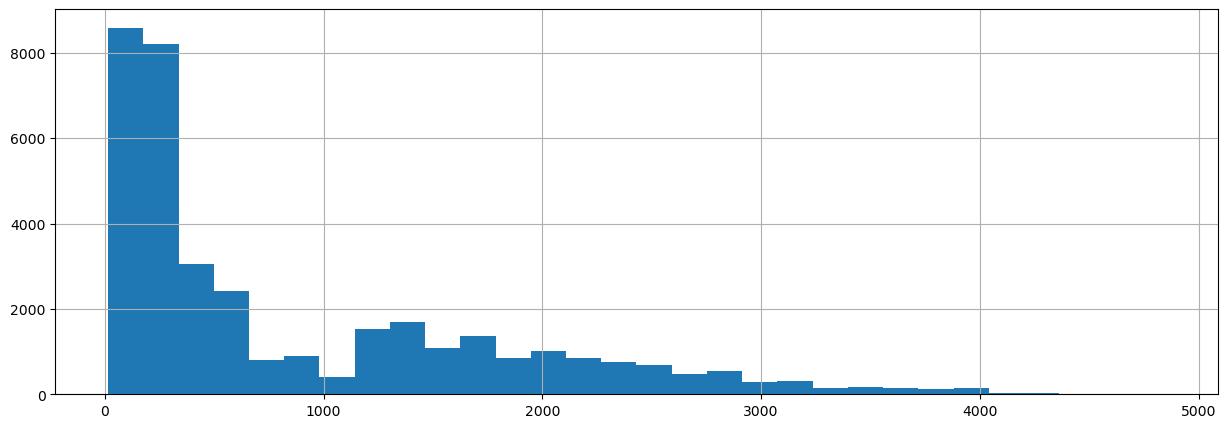

In [143]:
# Distribution of the number of days since first review
df.day_since_first_review.hist(figsize=(15,5), bins=30);

#### One-hot Encoding

In [144]:
df_listing['host_response_time'].fillna('unknown',inplace=True)
df_original = df_listing.copy()

In [145]:
# Find the first category for the 'neighbourhood_cleansed' column
dropped_category = df_original['neighbourhood_cleansed'].astype('category').cat.categories[0]

print("Dropped category for 'neighbourhood_cleansed':", dropped_category)


Dropped category for 'neighbourhood_cleansed': Barking and Dagenham


In [146]:
df_listing=pd.get_dummies(df_listing, drop_first=True)

# df_listing = pd.get_dummies(df_listing)

df_listing.shape

(36636, 180)

In [147]:
df_listing.sample()

host_id  host_response_rate  host_acceptance_rate  \
id                                                                       
682393455264365980  29311441                 1.0                   1.0   

                    host_is_superhost  host_listings_count  \
id                                                           
682393455264365980                0.0                  1.0   

                    host_total_listings_count  host_has_profile_pic  \
id                                                                    
682393455264365980                        2.0                     1   

                    host_identity_verified   latitude  longitude  \
id                                                                 
682393455264365980                       1  51.550913  -0.206132   

                    accommodates  bedrooms  beds  price  minimum_nights  \
id                                                                        
682393455264365980             4       2.0   2.0  140.0               6   

                    maximum_nights  minimum_minimum_nights  \
id                                                           
682393455264365980             365                     6.0   

                    maximum_minimum_nights  minimum_maximum_nights  \
id                                                                   
682393455264365980                     6.0                   365.0   

                    maximum_maximum_nights  minimum_nights_avg_ntm  \
id                                                                   
682393455264365980                   365.0                     6.0   

                    maximum_nights_avg_ntm  has_availability  availability_30  \
id                                                                              
682393455264365980                   365.0                 1                0   

                    availability_60  availability_90  availability_365  \
id                                                                       
682393455264365980                0                0                20   

                    number_of_reviews  number_of_reviews_ltm  \
id                                                             
682393455264365980                  2                      2   

                    number_of_reviews_l30d  review_scores_rating  \
id                                                                 
682393455264365980                       0                   5.0   

                    review_scores_accuracy  review_scores_cleanliness  \
id                                                                      
682393455264365980                     5.0                        4.5   

                    review_scores_checkin  review_scores_communication  \
id                                                                       
682393455264365980                    5.0                          5.0   

                    review_scores_location  review_scores_value  \
id                                                                
682393455264365980                     5.0                  4.5   

                    instant_bookable  calculated_host_listings_count  \
id                                                                     
682393455264365980                 0                               1   

                    calculated_host_listings_count_entire_homes  \
id                                                                
682393455264365980                                            1   

                    calculated_host_listings_count_private_rooms  \
id                                                                 
682393455264365980                                             0   

                    calculated_host_listings_count_shared_rooms  \
id                                                                
682393455264365980                                            0   

                    r

In [148]:
df_listing[['neighbourhood_cleansed_Westminster']].value_counts()

neighbourhood_cleansed_Westminster
0                                     32137
1                                      4499
dtype: int64

In [149]:
df_listing.nunique()

host_id                                             21138
host_response_rate                                     75
host_acceptance_rate                                   98
host_is_superhost                                       2
host_listings_count                                   111
host_total_listings_count                             162
host_has_profile_pic                                    2
host_identity_verified                                  2
latitude                                            19954
longitude                                           25316
accommodates                                           16
bedrooms                                               12
beds                                                   19
price                                                 999
minimum_nights                                         76
maximum_nights                                        230
minimum_minimum_nights                                 75
maximum_minimu

### Numerical features

In [150]:
nulls = df_listing.isnull().sum()
nulls = nulls[nulls!=0]
nulls

host_response_rate             3516
host_acceptance_rate            405
host_is_superhost                 1
bedrooms                       1776
beds                            467
review_scores_accuracy            1
review_scores_cleanliness         3
review_scores_checkin             1
review_scores_communication       2
review_scores_location            1
review_scores_value               1
bathrooms                        32
description_length              372
dtype: int64

In [151]:
df_listing['host_is_superhost'].fillna(0,inplace=True)

In [152]:
df_listing['bedrooms'].describe().round(0)

count    34860.0
mean         2.0
std          1.0
min          1.0
25%          1.0
50%          1.0
75%          2.0
max         22.0
Name: bedrooms, dtype: float64

In [153]:
df_listing['bathrooms'].describe().round(0)

count    36604.0
mean         1.0
std          1.0
min          0.0
25%          1.0
50%          1.0
75%          2.0
max         12.0
Name: bathrooms, dtype: float64

In [154]:
df_listing['host_response_rate'].describe().round(0)

count    33120.0
mean         1.0
std          0.0
min          0.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: host_response_rate, dtype: float64

In [155]:
# fillna with median for columns that have zero and zero for those that don't have zero

fill_na(df_listing)

fill nulls with median for: host_response_rate
fill nulls with median for: host_acceptance_rate
fill nulls with 0 for: bedrooms
fill nulls with 0 for: beds
fill nulls with 0 for: review_scores_accuracy
fill nulls with 0 for: review_scores_cleanliness
fill nulls with 0 for: review_scores_checkin
fill nulls with 0 for: review_scores_communication
fill nulls with 0 for: review_scores_location
fill nulls with 0 for: review_scores_value
fill nulls with median for: bathrooms
fill nulls with 0 for: description_length


In [156]:
sum(df_listing.isnull().sum())

0

## Amenities

In [157]:
amenities_df['amenities'].head()

id
825491308329325404    [washer, first aid kit, fire extinguisher, smo...
786791705194673775                                [washer, tv, kitchen]
749834503531737273    [washer, smoke alarm, free parking on premises...
717113207077160928                              [outdoor furniture, tv]
50584271              [washer, outdoor furniture, hangers, dishwashe...
Name: amenities, dtype: object

In [158]:
to_1D(amenities_df['amenities']).head()

0               washer
1        first aid kit
2    fire extinguisher
3          smoke alarm
4              kitchen
dtype: object

In [159]:
to_1D(amenities_df['amenities']).value_counts().head(300)

smoke alarm                                                                                           34236
kitchen                                                                                               33010
essentials                                                                                            32465
wifi                                                                                                  32398
iron                                                                                                  29299
hot water                                                                                             29183
hangers                                                                                               28903
dishes and silverware                                                                                 28051
hair dryer                                                                                            28021
carbon monoxide alarm       

In [160]:
pd.set_option('display.max_colwidth', None)

In [161]:
amenities_counts = to_1D(amenities_df['amenities']).value_counts().head(300).reset_index()

amenities_counts = amenities_counts.rename(columns={'index': 'amenity', 0: 'count'})

amenities_counts

amenity  \
0                                                                                           smoke alarm   
1                                                                                               kitchen   
2                                                                                            essentials   
3                                                                                                  wifi   
4                                                                                                  iron   
5                                                                                             hot water   
6                                                                                               hangers   
7                                                                                 dishes and silverware   
8                                                                                            hair dryer   
9                                                                                 carbon monoxide alarm   
10                                                                                         refrigerator   
11                                                                                       cooking basics   
12                                                                                           bed linens   
13                                                                                              heating   
14                                                                                            microwave   
15                                                                                              shampoo   
16                                                                                               washer   
17                                                                                  dedicated workspace   
18                                                                                     hot water kettle   
19                                                                                                 oven   
20                                                                                                   tv   
21                                                                              long term stays allowed   
22                                                                                    cleaning products   
23                                                                                              toaster   
24                                                                                              freezer   
25                                                                                              bathtub   
26                                                                                        first aid kit   
27                                                                                           shower gel   
28                                                                                    fire extinguisher   
29                                                                                         dining table   
30                                                                                           dishwasher   
31                                                                                        self check-in   
32                                                                           extra pillows and blankets   
33                                                                                                stove   
34                                                                                         wine glasses   
35                                                                             drying rack for clothing   
36                                                                                            body soap   
37                            

In [162]:
amenities_list = to_1D(amenities_df['amenities']).value_counts().head(300).index

In [163]:
amenities_list

Index(['smoke alarm', 'kitchen', 'essentials', 'wifi', 'iron', 'hot water',
       'hangers', 'dishes and silverware', 'hair dryer',
       'carbon monoxide alarm',
       ...
       'faith in nature conditioner', 'outdoor kitchen', '40" hdtv',
       'aesop body soap', 'fast wifi – 74 mbps', 'fast wifi – 72 mbps',
       'heating - split type ductless system', '32" hdtv with standard cable',
       'siemens stainless steel oven', 'faith in nature shampoo'],
      dtype='object', length=300)

In [164]:
amenities_df.shape

(36636, 2)

In [165]:
amenities_df = onehot_df(amenities_df,'amenities',amenities_list)

In [166]:
pd.reset_option('display.max_columns')

In [167]:
amenities_df.head(1)

listing_url  \
id                                                                    
825491308329325404  https://www.airbnb.com/rooms/825491308329325404   

                    amenities_smoke alarm  amenities_kitchen  \
id                                                             
825491308329325404                      1                  1   

                    amenities_essentials  amenities_wifi  amenities_iron  \
id                                                                         
825491308329325404                     0               1               0   

                    amenities_hot water  amenities_hangers  \
id                                                           
825491308329325404                    0                  0   

                    amenities_dishes and silverware  amenities_hair dryer  \
id                                                                          
825491308329325404                                0                     0   

                    ...  amenities_faith in nature conditioner  \
id                  ...                                          
825491308329325404  ...                                      0   

                    amenities_outdoor kitchen  amenities_40" hdtv  \
id                                                                  
825491308329325404                          0                   0   

                    amenities_aesop body soap  amenities_fast wifi – 74 mbps  \
id                                                                             
825491308329325404                          0                              0   

                    amenities_fast wifi – 72 mbps  \
id                                                  
825491308329325404                              0   

                    amenities_heating - split type ductless system  \
id                                                                   
825491308329325404                                               0   

                    amenities_32" hdtv with standard cable  \
id                                                           
825491308329325404                                       0   

                    amenities_siemens stainless steel oven  \
id                                                           
825491308329325404                                       0   

                    amenities_faith in nature shampoo  
id                                                     
825491308329325404                                  0  

[1 rows x 301 columns]

In [168]:
amenities_df.drop(['listing_url'],axis=1,inplace=True)

In [169]:
amenities_df.shape

(36636, 300)

In [170]:
amenities_df.head(1)

amenities_smoke alarm  amenities_kitchen  \
id                                                             
825491308329325404                      1                  1   

                    amenities_essentials  amenities_wifi  amenities_iron  \
id                                                                         
825491308329325404                     0               1               0   

                    amenities_hot water  amenities_hangers  \
id                                                           
825491308329325404                    0                  0   

                    amenities_dishes and silverware  amenities_hair dryer  \
id                                                                          
825491308329325404                                0                     0   

                    amenities_carbon monoxide alarm  ...  \
id                                                   ...   
825491308329325404                                1  ...   

                    amenities_faith in nature conditioner  \
id                                                          
825491308329325404                                      0   

                    amenities_outdoor kitchen  amenities_40" hdtv  \
id                                                                  
825491308329325404                          0                   0   

                    amenities_aesop body soap  amenities_fast wifi – 74 mbps  \
id                                                                             
825491308329325404                          0                              0   

                    amenities_fast wifi – 72 mbps  \
id                                                  
825491308329325404                              0   

                    amenities_heating - split type ductless system  \
id                                                                   
825491308329325404                                               0   

                    amenities_32" hdtv with standard cable  \
id                                                           
825491308329325404                                       0   

                    amenities_siemens stainless steel oven  \
id                                                           
825491308329325404                                       0   

                    amenities_faith in nature shampoo  
id                                                     
825491308329325404                                  0  

[1 rows x 300 columns]

In [171]:
columns = [
    'amenities_smoke alarm','amenities_kitchen','amenities_essentials','amenities_wifi','amenities_iron',
    'amenities_hot water','amenities_hangers','amenities_dishes and silverware','amenities_hair dryer',
    'amenities_carbon monoxide alarm'
]

for col in columns:
    print(f"\nValue counts for '{col}':")
    display(amenities_df[col].value_counts().to_frame())


Value counts for 'amenities_smoke alarm':


amenities_smoke alarm
1                  34236
0                   2400


Value counts for 'amenities_kitchen':


amenities_kitchen
1              33010
0               3626


Value counts for 'amenities_essentials':


amenities_essentials
1                 32465
0                  4171


Value counts for 'amenities_wifi':


amenities_wifi
1           32398
0            4238


Value counts for 'amenities_iron':


amenities_iron
1           29299
0            7337


Value counts for 'amenities_hot water':


amenities_hot water
1                29183
0                 7453


Value counts for 'amenities_hangers':


amenities_hangers
1              28903
0               7733


Value counts for 'amenities_dishes and silverware':


amenities_dishes and silverware
1                            28051
0                             8585


Value counts for 'amenities_hair dryer':


amenities_hair dryer
1                 28021
0                  8615


Value counts for 'amenities_carbon monoxide alarm':


amenities_carbon monoxide alarm
1                            26555
0                            10081

In [172]:
amenities_df.nunique().value_counts()

2    300
dtype: int64

In [173]:
amenities_df.head(1)

amenities_smoke alarm  amenities_kitchen  \
id                                                             
825491308329325404                      1                  1   

                    amenities_essentials  amenities_wifi  amenities_iron  \
id                                                                         
825491308329325404                     0               1               0   

                    amenities_hot water  amenities_hangers  \
id                                                           
825491308329325404                    0                  0   

                    amenities_dishes and silverware  amenities_hair dryer  \
id                                                                          
825491308329325404                                0                     0   

                    amenities_carbon monoxide alarm  ...  \
id                                                   ...   
825491308329325404                                1  ...   

                    amenities_faith in nature conditioner  \
id                                                          
825491308329325404                                      0   

                    amenities_outdoor kitchen  amenities_40" hdtv  \
id                                                                  
825491308329325404                          0                   0   

                    amenities_aesop body soap  amenities_fast wifi – 74 mbps  \
id                                                                             
825491308329325404                          0                              0   

                    amenities_fast wifi – 72 mbps  \
id                                                  
825491308329325404                              0   

                    amenities_heating - split type ductless system  \
id                                                                   
825491308329325404                                               0   

                    amenities_32" hdtv with standard cable  \
id                                                           
825491308329325404                                       0   

                    amenities_siemens stainless steel oven  \
id                                                           
825491308329325404                                       0   

                    amenities_faith in nature shampoo  
id                                                     
825491308329325404                                  0  

[1 rows x 300 columns]

In [174]:
df_listing.shape

(36636, 180)

In [175]:
# merge the two dataframes
df_listing = df_listing.join(amenities_df,how='left')
df_listing.reset_index(inplace=True)

In [176]:
print(df_listing.shape)

df_listing.head()

(36636, 481)


id    host_id  host_response_rate  host_acceptance_rate  \
0  825491308329325404  500808473                1.00                  1.00   
1  786791705194673775  490795350                0.98                  0.87   
2  749834503531737273  407681693                1.00                  1.00   
3  717113207077160928   48602573                1.00                  1.00   
4            50584271   27697324                1.00                  0.93   

   host_is_superhost  host_listings_count  host_total_listings_count  \
0                0.0                  1.0                        1.0   
1                0.0                 25.0                       26.0   
2                0.0                  2.0                        4.0   
3                1.0                  2.0                        5.0   
4                1.0                  3.0                        3.0   

   host_has_profile_pic  host_identity_verified   latitude  ...  \
0                     0                       0  51.416047  ...   
1                     0                       1  51.370691  ...   
2                     1                       1  51.613340  ...   
3                     1                       1  51.640408  ...   
4                     1                       1  51.401850  ...   

   amenities_faith in nature conditioner  amenities_outdoor kitchen  \
0                                      0                          0   
1                                      0                          0   
2                                      0                          0   
3                                      0                          0   
4                                      0                          0   

   amenities_40" hdtv  amenities_aesop body soap  \
0                   0                          0   
1                   0                          0   
2                   0                          0   
3                   0                          0   
4                   0                          0   

   amenities_fast wifi – 74 mbps  amenities_fast wifi – 72 mbps  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   amenities_heating - split type ductless system  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   amenities_32" hdtv with standard cable  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   amenities_siemens stainless steel oven  amenities_faith in nature shampoo  
0                                       0                                  0  
1                                       0                                  0  
2                                       0                                  0  
3                                       0                                  0  
4                                       0                                  0  

[5 rows x 481 columns]

## Multi listing

In [177]:
listing_by_host = host_id_df.groupby('host_id').size().reset_index(name='count')

In [178]:
listing_by_host.head()

host_id  count
0     4775      7
1     4879      1
2     6774      5
3     9323      1
4    10115      2

In [179]:
listing_by_host[['count']].describe().round(2)

count
count  21138.00
mean       1.73
std        3.52
min        1.00
25%        1.00
50%        1.00
75%        1.00
max      167.00

In [180]:
listing_by_host['multi_listing'] = listing_by_host['count'].map(lambda x:1 if x>1 else 0)

In [181]:
listing_by_host.head(10)

host_id  count  multi_listing
0     4775      7              1
1     4879      1              0
2     6774      5              1
3     9323      1              0
4    10115      2              1
5    10657      2              1
6    11431      1              0
7    19195      1              0
8    24334      1              0
9    26648      1              0

In [182]:
listing_by_host[['multi_listing']].value_counts(dropna=False)

multi_listing
0                16354
1                 4784
dtype: int64

In [183]:
listing_by_host.drop(['count'],axis=1,inplace=True)

listing_by_host.shape

(21138, 2)

In [184]:
df_listing.head(1)

id    host_id  host_response_rate  host_acceptance_rate  \
0  825491308329325404  500808473                 1.0                   1.0   

   host_is_superhost  host_listings_count  host_total_listings_count  \
0                0.0                  1.0                        1.0   

   host_has_profile_pic  host_identity_verified   latitude  ...  \
0                     0                       0  51.416047  ...   

   amenities_faith in nature conditioner  amenities_outdoor kitchen  \
0                                      0                          0   

   amenities_40" hdtv  amenities_aesop body soap  \
0                   0                          0   

   amenities_fast wifi – 74 mbps  amenities_fast wifi – 72 mbps  \
0                              0                              0   

   amenities_heating - split type ductless system  \
0                                               0   

   amenities_32" hdtv with standard cable  \
0                                       0   

   amenities_siemens stainless steel oven  amenities_faith in nature shampoo  
0                                       0                                  0  

[1 rows x 481 columns]

In [185]:
df_listing.shape

(36636, 481)

In [186]:
df_listing = pd.merge(df_listing,listing_by_host,on='host_id',how='left')

df_listing.shape

(36636, 482)

In [187]:
df_listing[['multi_listing']].head(10)

multi_listing
0              0
1              1
2              0
3              1
4              1
5              1
6              0
7              1
8              1
9              0

In [188]:
df_listing[['multi_listing']].value_counts(dropna=False)

multi_listing
1                20282
0                16354
dtype: int64

## Sentiment analysis

In [152]:
pd.reset_option('display.max_colwidth')

In [153]:
df_review = pd.read_csv('data/reviews.csv', encoding='utf-8')
df_review.shape

(1352432, 6)

In [154]:
df_review.head()

listing_id      id        date  reviewer_id reviewer_name  \
0       13913   80770  2010-08-18       177109       Michael   
1       13913  367568  2011-07-11     19835707       Mathias   
2       13913  529579  2011-09-13      1110304       Kristin   
3       13913  595481  2011-10-03      1216358       Camilla   
4       13913  612947  2011-10-09       490840         Jorik   

                                            comments  
0  My girlfriend and I hadn't known Alina before ...  
1  Alina was a really good host. The flat is clea...  
2  Alina is an amazing host. She made me feel rig...  
3  Alina's place is so nice, the room is big and ...  
4  Nice location in Islington area, good for shor...

In [155]:
df_review.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         106
dtype: int64

In [156]:
df_review = df_review.dropna(subset=['comments'])

print(df_review.shape)
df_review.head()

(1352326, 6)


listing_id      id        date  reviewer_id reviewer_name  \
0       13913   80770  2010-08-18       177109       Michael   
1       13913  367568  2011-07-11     19835707       Mathias   
2       13913  529579  2011-09-13      1110304       Kristin   
3       13913  595481  2011-10-03      1216358       Camilla   
4       13913  612947  2011-10-09       490840         Jorik   

                                            comments  
0  My girlfriend and I hadn't known Alina before ...  
1  Alina was a really good host. The flat is clea...  
2  Alina is an amazing host. She made me feel rig...  
3  Alina's place is so nice, the room is big and ...  
4  Nice location in Islington area, good for shor...

In [157]:
df_review[df_review['comments'].str.len()==2]

listing_id                  id        date  reviewer_id  \
9646                 274740           246832404  2018-03-26      5491798   
14581                 73884  538209919573248174  2022-01-12     28357845   
17240                344094           110905241  2016-10-29     98694319   
19649                 84223            88539783  2016-07-24     61571212   
19774                351727           347434078  2018-11-11     85696955   
...                     ...                 ...         ...          ...   
1349368  804133784391047309  833160550697667711  2023-02-23    496343909   
1351100  818775491631145713  844127063938467607  2023-03-10    199866598   
1351390  822344985422710511  828882706524363796  2023-02-17    218379369   
1351430  822421977077141602  824548741421542919  2023-02-11    456221071   
1351677  826092432654643799  833935965550405649  2023-02-24    323705803   

        reviewer_name comments  
9646             Anne       No  
14581          Nadeem       a+  
17240         Antonio       Ok  
19649        Jingyuan       ok  
19774      Alessandro       ok  
...               ...      ...  
1349368       Stephen       👍🏼  
1351100         Vicky       很好  
1351390       Sandeep       So  
1351430      Abdullah       👍👍  
1351677          Omar       ..  

[1122 rows x 6 columns]

In [158]:
df_review['comments'] = df_review['comments'].apply(remove_html_tags)
df_review = df_review[df_review['comments'].str.len()>1]

print(df_review.shape)
df_review.head()

(1349418, 6)


listing_id      id        date  reviewer_id reviewer_name  \
0       13913   80770  2010-08-18       177109       Michael   
1       13913  367568  2011-07-11     19835707       Mathias   
2       13913  529579  2011-09-13      1110304       Kristin   
3       13913  595481  2011-10-03      1216358       Camilla   
4       13913  612947  2011-10-09       490840         Jorik   

                                            comments  
0  My girlfriend and I hadn't known Alina before ...  
1  Alina was a really good host. The flat is clea...  
2  Alina is an amazing host. She made me feel rig...  
3  Alina's place is so nice, the room is big and ...  
4  Nice location in Islington area, good for shor...

### Comment length

In [159]:
df_review['comments_length'] = df_review['comments'].str.split().apply(len)

In [160]:
df_review[['comments_length']].head(10)

comments_length
0              149
1               32
2               68
3               86
4               17
5              149
6               66
7               13
8               75
9               42

In [161]:
df_review[['comments']].head(10)

comments
0  My girlfriend and I hadn't known Alina before ...
1  Alina was a really good host. The flat is clea...
2  Alina is an amazing host. She made me feel rig...
3  Alina's place is so nice, the room is big and ...
4  Nice location in Islington area, good for shor...
5  I'm very happy to have been Alina's guest! We'...
6  I stayed with Alina in her flat in London for ...
7  Alina was a perfect guest and her flat is abso...
8  Alina's flat is exceptional one.  \r I have to...
9  The House is a piece of Art , there are beauti...

In [162]:
print(df_review['comments'].iloc[6])

I stayed with Alina in her flat in London for a week. It's a wonderful home with a warm feeling and everything you need. Alina went out of her way to make sure I was comfortable and we shared some great chats and meals. I recommend Alina's place to anyone looking for a home for a while in London, and look forward to seeing Alina again. 


In [154]:
df_review[['comments_length']].value_counts()

comments_length
14                 35078
6                  26098
7                  25269
8                  25220
9                  24942
10                 24838
13                 24783
11                 24615
12                 24440
2                  24179
5                  23905
15                 23690
4                  23670
16                 23070
17                 22668
18                 22319
19                 22128
20                 21738
21                 21374
22                 20946
23                 20775
24                 20505
25                 19983
26                 19610
27                 19274
28                 18688
29                 18383
30                 18162
1                  17834
31                 17553
32                 17206
33                 17098
34                 16495
35                 16296
36                 15588
37                 15385
38                 14962
39                 14586
40                 14108
41       

### Detect language & filter only English

In [155]:
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

df_review['language'] = df_review['comments'].apply(language_detection)

In [156]:
df_language_counts = df_review['language'].value_counts().reset_index()
df_language_counts = df_language_counts.rename(columns={'index': 'language', 'language': 'count'})

In [157]:
df_language_counts

language    count
0        en  1174041
1        fr    56246
2        es    29687
3        de    20511
4        it    12442
5        ko     9670
6     zh-cn     7822
7        pt     6428
8        nl     4822
9        ro     3456
10       so     2599
11       ca     2420
12       af     1952
13       pl     1638
14       cs     1521
15       ja     1468
16       da     1458
17       no     1111
18       ru     1098
19       sv     1090
20       tl      795
21    zh-tw      732
22       cy      593
23       hu      572
24       fi      544
25       he      505
26       ar      447
27       id      424
28       tr      423
29       sw      324
30       sk      261
31       el      259
32       hr      256
33       et      237
34       vi      137
35       sl      109
36       lt       55
37       uk       51
38       lv       40
39       bg       39
40       th       35
41       sq       32
42       fa       11
43       ur       10
44       mk        8

In [158]:
df_review[['language']].describe()

language
count   1348379
unique       45
top          en
freq    1174041

In [159]:
df_review = df_review[df_review['language']=='en'].reset_index(drop=True)

In [160]:
df_review.head(1)

listing_id     id        date  reviewer_id reviewer_name  \
0       13913  80770  2010-08-18       177109       Michael   

                                            comments  comments_length language  
0  My girlfriend and I hadn't known Alina before ...              149       en

In [161]:
df_review.shape

(1174041, 8)

### Textblob sentiment scores

In [162]:
def textblob_sentiment_scores(text):
    textblob_sentiment = TextBlob(text)
    score = textblob_sentiment.sentiment.polarity
    return score

df_review['textblob_score'] = df_review['comments'].apply(textblob_sentiment_scores)

In [165]:
df_review[['textblob_score']].describe().round(2)

textblob_score
count      1174041.00
mean             0.41
std              0.20
min             -1.00
25%              0.29
50%              0.40
75%              0.52
max              1.00

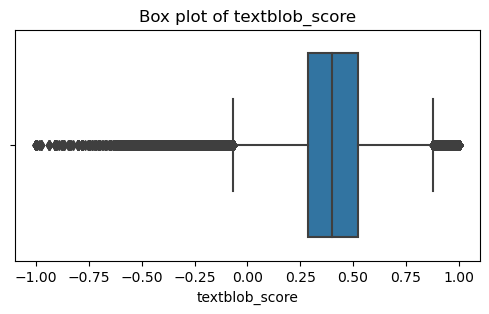

In [166]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=df_review['textblob_score'])
plt.title('Box plot of textblob_score')
plt.show()

In [167]:
df_review[['comments','textblob_score']]

comments  textblob_score
0        My girlfriend and I hadn't known Alina before ...        0.264382
1        Alina was a really good host. The flat is clea...        0.306944
2        Alina is an amazing host. She made me feel rig...        0.280812
3        Alina's place is so nice, the room is big and ...        0.404978
4        Nice location in Islington area, good for shor...        0.457500
...                                                    ...             ...
1174036  Great place to stay, enjoyed every min of the ...        0.766667
1174037  Was a great place to stay, felt home away from...        0.500000
1174038  Natalie was extremely helpful responding to qu...        0.213889
1174039  Great place to stay; great balance between mon...        0.386667
1174040  5mins walk from tube station, clear instructio...        0.233333

[1174041 rows x 2 columns]

### Drop automated postings

In [168]:
pd.set_option('display.max_colwidth', None)

In [169]:
df_review[df_review['comments'].str.contains(
    'This is an automated posting.')][['comments','textblob_score']].reset_index(drop=True)

comments  \
0      The host canceled this reservation 53 days before arrival. This is an automated posting.   
1             The reservation was canceled 3 days before arrival. This is an automated posting.   
2      The host canceled this reservation 58 days before arrival. This is an automated posting.   
3      The host canceled this reservation 35 days before arrival. This is an automated posting.   
4             The reservation was canceled 9 days before arrival. This is an automated posting.   
...                                                                                         ...   
12004   The host canceled this reservation 9 days before arrival. This is an automated posting.   
12005  The host canceled this reservation the day before arrival. This is an automated posting.   
12006   The host canceled this reservation 9 days before arrival. This is an automated posting.   
12007   The host canceled this reservation 3 days before arrival. This is an automated posting.   
12008   The host canceled this reservation 7 days before arrival. This is an automated posting.   

       textblob_score  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
...               ...  
12004             0.0  
12005             0.0  
12006             0.0  
12007             0.0  
12008             0.0  

[12009 rows x 2 columns]

In [170]:
df_review = df_review[~df_review['comments'].str.contains('This is an automated posting')].reset_index(drop=True)

In [171]:
pd.reset_option('display.max_colwidth')

In [172]:
df_review.shape

(1162032, 9)

In [173]:
df_review.head()

listing_id      id        date  reviewer_id reviewer_name  \
0       13913   80770  2010-08-18       177109       Michael   
1       13913  367568  2011-07-11     19835707       Mathias   
2       13913  529579  2011-09-13      1110304       Kristin   
3       13913  595481  2011-10-03      1216358       Camilla   
4       13913  612947  2011-10-09       490840         Jorik   

                                            comments  comments_length  \
0  My girlfriend and I hadn't known Alina before ...              149   
1  Alina was a really good host. The flat is clea...               32   
2  Alina is an amazing host. She made me feel rig...               68   
3  Alina's place is so nice, the room is big and ...               86   
4  Nice location in Islington area, good for shor...               17   

  language  textblob_score  
0       en        0.264382  
1       en        0.306944  
2       en        0.280812  
3       en        0.404978  
4       en        0.457500

### Key reviewers (having reviews more than 1)

In [174]:
reviewer = df_review.groupby('reviewer_id').size().reset_index(name='count')

In [175]:
reviewer

reviewer_id  count
0               259      1
1               283      1
2               287      2
3               333      1
4               706      1
...             ...    ...
973379    504738209      1
973380    504794751      1
973381    504870328      1
973382    504910058      1
973383    504952807      1

[973384 rows x 2 columns]

In [176]:
reviewer[['count']].describe().round(2)

count
count  973384.00
mean        1.19
std         0.83
min         1.00
25%         1.00
50%         1.00
75%         1.00
max       133.00

In [177]:
reviewer.shape

(973384, 2)

In [178]:
reviewer[reviewer['count']>1].reset_index(drop=True)

reviewer_id  count
0               287      2
1              1698      4
2              1826      2
3              2784      9
4              2833      2
...             ...    ...
114488    502173344      2
114489    502198414      2
114490    502265178      2
114491    502504211      2
114492    502697291      2

[114493 rows x 2 columns]

In [179]:
key_reviewer = reviewer[reviewer['count']>1].reset_index(drop=True)['reviewer_id'].values

In [180]:
len(key_reviewer)

114493

In [181]:
df_review['key_reviewer'] = np.where(df_review['reviewer_id'].isin(key_reviewer), 1, 0)

In [182]:
df_review[['reviewer_id','key_reviewer']]

reviewer_id  key_reviewer
0             177109             0
1           19835707             1
2            1110304             0
3            1216358             0
4             490840             0
...              ...           ...
1162027    433279721             1
1162028    489943356             1
1162029    481779440             0
1162030    433152443             0
1162031    489030148             0

[1162032 rows x 2 columns]

In [183]:
# check the result
print(433279721 in key_reviewer)
print(177109 in key_reviewer)

True
False


In [184]:
df_review.head(1)

listing_id     id        date  reviewer_id reviewer_name  \
0       13913  80770  2010-08-18       177109       Michael   

                                            comments  comments_length  \
0  My girlfriend and I hadn't known Alina before ...              149   

  language  textblob_score  key_reviewer  
0       en        0.264382             0

In [185]:
review_group = df_review[['listing_id','comments_length','textblob_score',
                          'key_reviewer']].groupby(by='listing_id').mean().reset_index()

In [186]:
print(review_group.shape)

review_group.head()

(54390, 4)


listing_id  comments_length  textblob_score  key_reviewer
0       13913        40.125000        0.426355      0.450000
1       15400        73.988372        0.393211      0.209302
2       17402        74.386364        0.406447      0.136364
3       24328        68.000000        0.408263      0.130952
4       25123        59.898148        0.391549      0.250000

In [187]:
review_group.to_csv('data/reviews_clean.csv',index=False)

In [137]:
# read in the clean review version (to save time)
reviews_clean = pd.read_csv('data/reviews_clean.csv')
reviews_clean.shape

(54390, 4)

In [138]:
reviews_clean.head()

listing_id  comments_length  textblob_score  key_reviewer
0       13913        40.125000        0.426355      0.450000
1       15400        73.988372        0.393211      0.209302
2       17402        74.386364        0.406447      0.136364
3       24328        68.000000        0.408263      0.130952
4       25123        59.898148        0.391549      0.250000

In [139]:
# merge these two dataframes
df_listing = df_listing.rename(columns={'id':'listing_id'})

merged_df = df_listing.merge(reviews_clean,on='listing_id',how='left')

In [140]:
merged_df.shape

(36636, 485)

In [141]:
print(merged_df.columns[merged_df.isnull().sum()>0])

Index(['comments_length', 'textblob_score', 'key_reviewer'], dtype='object')


In [142]:
columns=['comments_length','textblob_score','key_reviewer']

for col in columns:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mean())

merged_df.shape

(36636, 485)

In [143]:
merged_df.isnull().sum().sum()

0

## Normalized space for longitude and latitude

In [144]:
lat, lon = merged_df['latitude'], merged_df['longitude']

merged_df['geo_x'] = np.multiply(np.cos(lat), np.cos(lon))
merged_df['geo_y'] = np.multiply(np.cos(lat), np.sin(lon))
merged_df['geo_z'] = np.sin(lat)

In [145]:
merged_df.shape

(36636, 488)

## Log transform price

In [146]:
merged_df['price'].describe().round(2)

count    36636.00
mean       170.58
std        301.04
min         10.00
25%         70.00
50%        120.00
75%        195.00
max      35243.00
Name: price, dtype: float64

In [147]:
from scipy.stats import shapiro

stat, p = shapiro(merged_df['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.264, p=0.000
Sample does not look Gaussian (reject H0)


In [148]:
merged_df['price_log'] = np.log(merged_df['price'])

In [149]:
merged_df['price_log'].describe()

count    36636.000000
mean         4.798676
std          0.754045
min          2.302585
25%          4.248495
50%          4.787492
75%          5.273000
max         10.470022
Name: price_log, dtype: float64

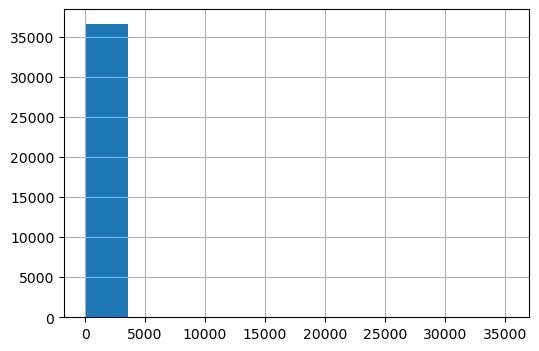

In [150]:
merged_df['price'].hist(figsize=(6,4));

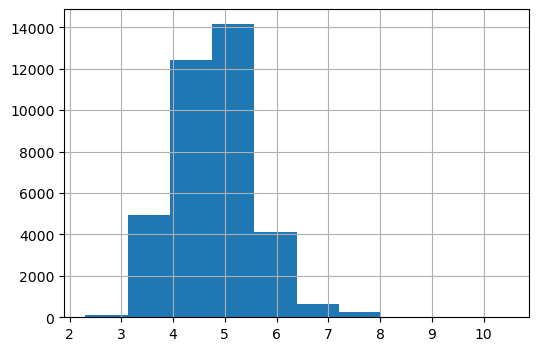

In [151]:
merged_df['price_log'].hist(figsize=(6,4));

In [152]:
merged_df.shape

(36636, 489)

In [154]:
# merged_df.to_csv('data/airbnb_clean2.csv',index=False)

In [225]:
# merged_df.to_csv('data/airbnb_clean.csv',index=False)

In [155]:
airbnb = pd.read_csv('data/airbnb_clean2.csv')
airbnb.shape

(36636, 489)

In [156]:
airbnb[['price_log','price']]

price_log  price
0       3.761200   43.0
1       4.605170  100.0
2       3.367296   29.0
3       4.077537   59.0
4       4.007333   55.0
...          ...    ...
36631   4.174387   65.0
36632   4.753590  116.0
36633   4.234107   69.0
36634   4.941642  140.0
36635   5.099866  164.0

[36636 rows x 2 columns]

## Add some OpenStreetMap features ('attraction' & 'restaurant' within certain distance from a listing)

In [157]:
map_df = gpd.read_file('data/neighbourhoods.geojson')

In [158]:
print(map_df.shape)

map_df

(33, 3)


neighbourhood  neighbourhood_group  \
0     Kingston upon Thames                  NaN   
1                  Croydon                  NaN   
2                  Bromley                  NaN   
3                 Hounslow                  NaN   
4                   Ealing                  NaN   
5                 Havering                  NaN   
6               Hillingdon                  NaN   
7                   Harrow                  NaN   
8                    Brent                  NaN   
9                   Barnet                  NaN   
10                 Enfield                  NaN   
11          Waltham Forest                  NaN   
12               Redbridge                  NaN   
13                  Sutton                  NaN   
14                 Lambeth                  NaN   
15               Southwark                  NaN   
16                Lewisham                  NaN   
17               Greenwich                  NaN   
18                  Bexley                  NaN   
19    Richmond upon Thames                  NaN   
20                  Merton                  NaN   
21              Wandsworth                  NaN   
22  Hammersmith and Fulham                  NaN   
23  Kensington and Chelsea                  NaN   
24          City of London                  NaN   
25             Westminster                  NaN   
26                  Camden                  NaN   
27           Tower Hamlets                  NaN   
28               Islington                  NaN   
29                 Hackney                  NaN   
30                Haringey                  NaN   
31                  Newham                  NaN   
32    Barking and Dagenham                  NaN   

                                             geometry  
0   MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  
1   MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...  
2   MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...  
3   MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...  
4   MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...  
5   MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...  
6   MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...  
7   MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...  
8   MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...  
9   MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...  
10  MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...  
11  MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...  
12  MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...  
13  MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...  
14  MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...  
15  MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...  
16  MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...  
17  MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51...  
18  MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5...  
19  MULTIPOLYGON (((-0.32173 51.46541, -0.32172 51...  
20  MULTIPOLYGON (((-0.13432 51.39093, -0.13438 51...  
21  MULTIPOLYGON (((-0.22343 51.47152, -0.22327 51...  
22  MULTIPOLYGON (((-0.24456 51.48870, -0.24460 51...  
23  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...  
24  MULTIPOLYGON (((-0.11157 51.51076, -0.11159 51...  
25  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...  
26  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...  
27  MULTIPOLYGON (((-0.07938 51.50784, -0.07934 51...  
28  MULTIPOLYGON (((-0.13839 51.55686, -0.13851 51...  
29  MULTIPOLYGON (((-0.09767 51.57365, -0.09756 51...  
30  MULTIPOLYGON (((-0.09767 51.57365, -0.09780 51...  
31  MULTIPOLYGON (((0.07549 51.52982, 0.07546 51.5...  
32  MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...

In [159]:
map_df.drop(['neighbourhood_group'],axis=1,inplace=True)

In [160]:
region = map_df['geometry'].unary_union

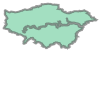

In [161]:
region

In [162]:
type(region)

shapely.geometry.polygon.Polygon

In [163]:
def get_local_crs(y,x):
    x = ox.utils_geo.bbox_from_point((y, x), dist=500, project_utm=True, return_crs=True)
    return x[-1]

In [164]:
london_latitude = 51.509865
london_longitude = -0.118092

local_utm_crs = get_local_crs(london_latitude,london_longitude)

In [165]:
local_utm_crs

<Projected CRS: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [166]:
def get_osm_data(region, data):   
    df = ox.features.features_from_polygon(region, tags=data[0])
    filename = f"data/{list(data[0].values())[0]}.csv"
    df.to_csv(filename, columns=['geometry'])
    return df

# attraction = get_osm_data(region, [{'tourism':'attraction'}])
# restaurant = get_osm_data(region, [{'amenity':'restaurant'}])

In [167]:
def import_csv_to_gpd(name):    
    df = pd.read_csv(f'data/{name}.csv', sep=",")
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, crs='epsg:4326')    
    return gdf

In [168]:
restaurant = import_csv_to_gpd('restaurant')
attraction = import_csv_to_gpd('attraction')

In [169]:
print(restaurant.shape)

restaurant.head()

(8093, 3)


element_type     osmid                   geometry
0         node    451153  POINT (-0.19350 51.60203)
1         node  26544484  POINT (-0.17223 51.39801)
2         node  26603928  POINT (-0.48171 51.52718)
3         node  26604024  POINT (-0.45855 51.52573)
4         node  26845558  POINT (-0.13256 51.51105)

In [170]:
print(attraction.shape)

attraction.head()

(359, 3)


element_type      osmid                   geometry
0         node   26559743  POINT (-0.14525 51.39520)
1         node  252602371  POINT (-0.08826 51.50639)
2         node  269236138  POINT (-0.17065 51.35530)
3         node  293221901   POINT (0.16023 51.44819)
4         node  320446994  POINT (-0.18974 51.56601)

In [171]:
def get_long_lat(point):
    try:
        return pd.Series([point.x, point.y])
    except:
        pass

def geo_coordinates(df):    
    df['geometry'] = df['geometry'].apply(
        lambda x: x.centroid if type(x) == Polygon else (x.centroid if type(x) == MultiPolygon else x))
    df[['long','lat']] = df.apply(lambda x: get_long_lat(x['geometry']), axis=1)
    df = df[df['geometry'].apply(lambda x: x.geom_type=='Point')]
    df = df.to_crs(local_utm_crs)    
    return df

In [172]:
attraction = geo_coordinates(attraction)
restaurant = geo_coordinates(restaurant)

In [173]:
print(restaurant.shape)

restaurant.head()

(8093, 5)


element_type     osmid                        geometry      long        lat
0         node    451153  POINT (694353.653 5720508.222) -0.193503  51.602031
1         node  26544484  POINT (696703.089 5697881.898) -0.172235  51.398014
2         node  26603928  POINT (674684.450 5711457.900) -0.481714  51.527176
3         node  26604024  POINT (676296.779 5711352.878) -0.458548  51.525732
4         node  26845558  POINT (698970.076 5710557.083) -0.132560  51.511054

In [174]:
print(attraction.shape)

attraction.head()

(345, 5)


element_type      osmid                        geometry      long        lat
0         node   26559743  POINT (698592.310 5697642.316) -0.145245  51.395205
1         node  252602371  POINT (702063.779 5710159.680) -0.088264  51.506388
2         node  269236138  POINT (696996.687 5693137.398) -0.170649  51.355303
3         node  293221901  POINT (719583.801 5704404.661)  0.160226  51.448185
4         node  320446994  POINT (694768.016 5716513.543) -0.189743  51.566012

In [175]:
def get_tree(df):
    try:
        coords = list(zip(df.geometry.apply(lambda x: x.y).values, df.geometry.apply(lambda x: x.x).values))
        tree = spatial.KDTree(coords)
        return tree
    except Exception as e:
        print(e)

def find_points_closeby(tree, lat_lon, k=500, max_distance=800):    
    results = tree.query(lat_lon, k=k, distance_upper_bound=max_distance)
    zipped_results = list(zip(results[0], results[1]))
    zipped_results = [i for i in zipped_results if i[0] != np.inf]    
    return len(zipped_results)

In [176]:
airbnb = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb['longitude'], airbnb['latitude']), crs=4326)

In [177]:
# add one column called "geometry"
airbnb.shape

(36636, 490)

In [178]:
airbnb[['geometry','longitude','latitude']]

geometry  longitude   latitude
0      POINT (-0.17430 51.41605)  -0.174299  51.416047
1      POINT (-0.10996 51.37069)  -0.109956  51.370691
2      POINT (-0.12591 51.61334)  -0.125910  51.613340
3      POINT (-0.18817 51.64041)  -0.188166  51.640408
4      POINT (-0.25576 51.40185)  -0.255760  51.401850
...                          ...        ...        ...
36631  POINT (-0.22621 51.54940)  -0.226210  51.549400
36632  POINT (-0.12608 51.46936)  -0.126080  51.469360
36633  POINT (-0.22371 51.55148)  -0.223710  51.551480
36634  POINT (-0.08893 51.54392)  -0.088931  51.543923
36635  POINT (-0.16678 51.53454)  -0.166780  51.534540

[36636 rows x 3 columns]

In [179]:
airbnb = airbnb.to_crs(local_utm_crs)

In [180]:
airbnb[['geometry','longitude','latitude']]

geometry  longitude   latitude
0      POINT (696482.177 5699881.294)  -0.174299  51.416047
1      POINT (701154.316 5695013.096)  -0.109956  51.370691
2      POINT (698984.187 5721947.611)  -0.125910  51.613340
3      POINT (694558.860 5724789.467)  -0.188166  51.640408
4      POINT (690877.968 5698087.428)  -0.255760  51.401850
...                               ...        ...        ...
36631  POINT (692311.164 5714569.983)  -0.226210  51.549400
36632  POINT (699601.708 5705939.092)  -0.126080  51.469360
36633  POINT (692475.679 5714807.826)  -0.223710  51.551480
36634  POINT (701851.391 5714331.012)  -0.088931  51.543923
36635  POINT (696494.813 5713075.786)  -0.166780  51.534540

[36636 rows x 3 columns]

In [181]:
parameters = [attraction, restaurant]
names = ['attraction','restaurant']

for name, i in zip(names, parameters):
    tree = get_tree(i)
    airbnb[name] = airbnb.apply(lambda row: find_points_closeby(tree, (row.geometry.y, row.geometry.x)), axis=1)

In [182]:
airbnb.shape

(36636, 492)

In [183]:
airbnb[['attraction','restaurant']]

attraction  restaurant
0               0          17
1               0          14
2               0           2
3               0           1
4               0          16
...           ...         ...
36631           0           7
36632           0          17
36633           0           6
36634           0          15
36635          14          12

[36636 rows x 2 columns]

In [186]:
# airbnb.to_csv('data/airbnb_osm2.csv',index=False)

In [187]:
# airbnb.to_csv('data/airbnb_osm.csv',index=False)

# Model

In [3]:
airbnb = pd.read_csv('data/airbnb_osm2.csv')
airbnb.shape

(36636, 492)

In [263]:
airbnb.head(1)

listing_id    host_id  host_response_rate  host_acceptance_rate  \
0  825491308329325404  500808473                 1.0                   1.0   

   host_is_superhost  host_listings_count  host_total_listings_count  \
0                0.0                  1.0                        1.0   

   host_has_profile_pic  host_identity_verified   latitude  longitude  \
0                     0                       0  51.416047  -0.174299   

   accommodates  bedrooms  beds  price  minimum_nights  maximum_nights  \
0             2       1.0   1.0   43.0               1             365   

   minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
0                     1.0                     1.0                   365.0   

   maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0                   365.0                     1.0                   365.0   

   has_availability  availability_30  availability_60  availability_90  \
0                 1               20               50               80   

   availability_365  number_of_reviews  number_of_reviews_ltm  \
0               278                  3                      3   

   number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  \
0                       3                  4.67                     5.0   

   review_scores_cleanliness  review_scores_checkin  \
0                       4.67                   4.67   

   review_scores_communication  review_scores_location  review_scores_value  \
0                          5.0                    4.67                 4.67   

   instant_bookable  calculated_host_listings_count  \
0                 0                               1   

   calculated_host_listings_count_entire_homes  \
0                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             1   

   calculated_host_listings_count_shared_rooms  reviews_per_month  bathrooms  \
0                                            0                3.0        1.0   

   amenities_count  description_length  host_duration  day_since_first_review  \
0                9                 2.0             45                      38   

   day_since_last_review  name_missing  description_missing  \
0                     16             0                    0   

   neighborhood_overview_missing  host_location_missing  host_about_missing  \
0                              1                      1                   1   

   host_acceptance_rate_missing  host_neighbourhood_missing  bedrooms_missing  \
0                             0                           1                 0   

   beds_missing  bathrooms_missing  host_response_time_a few days or more  \
0             0                  0                                      0   

   host_response_time_unknown  host_response_time_within a day  \
0                           0                                0   

   host_response_time_within a few hours  host_response_time_within an hour  \
0                                      0                                  1   

   neighbourhood_cleansed_Barking and Dagenham  neighbourhood_cleansed_Barnet  \
0                                            0                              0   

   neighbourhood_cleansed_Bexley  neighbourhood_cleansed_Brent  \
0                              0                             0   

   neighbourhood_cleansed_Bromley  neighbourhood_cleansed_Camden  \
0                               0                              0   

   neighbourhood_cleansed_City of London  neighbourhood_cleansed_Croydon  \
0                                      0                               0   

   neighbourhood_cleansed_Ealing  neighbourhood_cleansed_Enfield  \
0                              0                               0   

   neighbourhood_cleansed_Greenwich  neighbourhood_cleansed_Hackney  \
0                                 0                               0   

 

In [189]:
y = airbnb['price_log']
X = airbnb.drop(columns=['price','price_log','listing_id','host_id','latitude','longitude','geometry'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [265]:
y

0        3.761200
1        4.605170
2        3.367296
3        4.077537
4        4.007333
           ...   
36631    4.174387
36632    4.753590
36633    4.234107
36634    4.941642
36635    5.099866
Name: price_log, Length: 36636, dtype: float64

In [266]:
X

host_response_rate  host_acceptance_rate  host_is_superhost  \
0                    1.00                  1.00                0.0   
1                    0.98                  0.87                0.0   
2                    1.00                  1.00                0.0   
3                    1.00                  1.00                1.0   
4                    1.00                  0.93                1.0   
...                   ...                   ...                ...   
36631                0.99                  1.00                0.0   
36632                1.00                  0.54                1.0   
36633                0.99                  1.00                0.0   
36634                1.00                  1.00                0.0   
36635                1.00                  0.98                0.0   

       host_listings_count  host_total_listings_count  host_has_profile_pic  \
0                      1.0                        1.0                     0   
1                     25.0                       26.0                     0   
2                      2.0                        4.0                     1   
3                      2.0                        5.0                     1   
4                      3.0                        3.0                     1   
...                    ...                        ...                   ...   
36631                 79.0                      110.0                     1   
36632                  1.0                        1.0                     1   
36633                 79.0                      110.0                     1   
36634                  1.0                        1.0                     1   
36635                  6.0                        6.0                     1   

       host_identity_verified  accommodates  bedrooms  beds  minimum_nights  \
0                           0             2       1.0   1.0               1   
1                           1             6       3.0   5.0               2   
2                           1             1       1.0   1.0               1   
3                           1             2       1.0   1.0               1   
4                           1             2       1.0   0.0               1   
...                       ...           ...       ...   ...             ...   
36631                       1             2       1.0   1.0               2   
36632                       1             2       1.0   2.0               3   
36633                       1             2       0.0   1.0               2   
36634                       1             2       1.0   1.0               1   
36635                       1             2       1.0   1.0               1   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0                 365                     1.0                     1.0   
1                 365                     2.0                     2.0   
2                   6                     1.0                     1.0   
3                 365                     1.0                     1.0   
4                  14                     1.0                     1.0   
...               ...                     ...                     ...   
36631             500                     2.0                     2.0   
36632              30                     3.0                     3.0   
36633             365                     2.0                     2.0   
36634             365                     2.0                     3.0   
36635             365                     1.0                     1.0   

       minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                       365.0                   365.0                     1.0   
1                       365.0                   365.0                     2.0   
2                         6.0                     6.0                     1.0   
3                       365.0                   365.0              

In [268]:
X_train.head(1)

host_response_rate  host_acceptance_rate  host_is_superhost  \
19504                 1.0                  0.67                1.0   

       host_listings_count  host_total_listings_count  host_has_profile_pic  \
19504                  1.0                        1.0                     1   

       host_identity_verified  accommodates  bedrooms  beds  minimum_nights  \
19504                       0             2       1.0   1.0              30   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
19504            1125                    30.0                    90.0   

       minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
19504                  1125.0                  1125.0                    77.4   

       maximum_nights_avg_ntm  has_availability  availability_30  \
19504                  1125.0                 1                0   

       availability_60  availability_90  availability_365  number_of_reviews  \
19504                0                3               272                  4   

       number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  \
19504                      3                       0                   5.0   

       review_scores_accuracy  review_scores_cleanliness  \
19504                     5.0                        4.5   

       review_scores_checkin  review_scores_communication  \
19504                   4.75                          5.0   

       review_scores_location  review_scores_value  instant_bookable  \
19504                     4.5                 4.25                 0   

       calculated_host_listings_count  \
19504                               1   

       calculated_host_listings_count_entire_homes  \
19504                                            1   

       calculated_host_listings_count_private_rooms  \
19504                                             0   

       calculated_host_listings_count_shared_rooms  reviews_per_month  \
19504                                            0               0.22   

       bathrooms  amenities_count  description_length  host_duration  \
19504        1.0               40                91.0           3395   

       day_since_first_review  day_since_last_review  name_missing  \
19504                     563                    116             0   

       description_missing  neighborhood_overview_missing  \
19504                    0                              0   

       host_location_missing  host_about_missing  \
19504                      0                   1   

       host_acceptance_rate_missing  host_neighbourhood_missing  \
19504                             0                           0   

       bedrooms_missing  beds_missing  bathrooms_missing  \
19504                 0             0                  0   

       host_response_time_a few days or more  host_response_time_unknown  \
19504                                      0                           0   

       host_response_time_within a day  host_response_time_within a few hours  \
19504                                0                                      0   

       host_response_time_within an hour  \
19504                                  1   

       neighbourhood_cleansed_Barking and Dagenham  \
19504                                            0   

       neighbourhood_cleansed_Barnet  neighbourhood_cleansed_Bexley  \
19504                              0                              0   

       neighbourhood_cleansed_Brent  neighbourhood_cleansed_Bromley  \
19504                             0                               0   

       neighbourhood_cleansed_Camden  neighbourhood_cleansed_City of London  \
19504                              0                                      0   

       neighbourhood_cleansed_Croydon  neighbourhood_cleansed_Ealing  \
19504                               0                              0   

       neighbourhood_cleansed_Enfield  neighbourhood_cleansed_Greenwic

## Linear regression

In [269]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train,y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test,y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.129
MSE test: 0.139

R2 train: 0.775
R2 test: 0.750


## XGBoost

In [270]:
# default values for xgboost
xgbr = xgb.XGBRegressor(random_state=42,
                        n_estimators=100,
                        max_depth=6,
                        learning_rate=0.3)

xgbr.fit(X_train, y_train)

y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train,y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test,y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.045
MSE test: 0.101

R2 train: 0.921
R2 test: 0.819


In [13]:
# Manually change some parameters 
xgbr = xgb.XGBRegressor(random_state=42,
                        n_estimators=400,
                        max_depth=3,
                        learning_rate=0.3)

xgbr.fit(X_train, y_train)

y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train,y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test,y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.064
MSE test: 0.097

R2 train: 0.888
R2 test: 0.825


### Tuning the model with RandomizedSearchCV (Use Google Colab's GPU for this part)

In [14]:
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [37]:
def build_trained_model():

    parameters = {
        'n_estimators': list(np.arange(50, 500, 50)), # default=100
        'max_depth': list(np.arange(1, 10)), # default=6
        'learning_rate': list(np.linspace(0.01, 1, 20)) + [0.3], # default=0.3
        'subsample': [0.5, 0.7, 0.9, None]
        }

    start_time = time.time()
    print("Testing the following parameter combinations:")

    total_iterations = 1
    for key, value in parameters.items():
        print(f"{key}: {value}")
        total_iterations *= len(value)

    model = xgb.XGBRegressor(random_state=42, tree_method='gpu_hist')

    # Set the number of iterations for RandomizedSearchCV
    n_iter = min(total_iterations, 50)  # Limit the maximum number of iterations

    random_search = RandomizedSearchCV(model, param_distributions=parameters, n_iter=n_iter,
                                       scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)

    random_search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time
    print("")
    print("Randomized search complete.")
    print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")
    print("")
    print("Best parameters found:")
    print(random_search.best_params_)

    return random_search

model = build_trained_model()

Testing the following parameter combinations:
n_estimators: [50, 100, 150, 200, 250, 300, 350, 400, 450]
max_depth: [1, 2, 3, 4, 5, 6, 7, 8, 9]
learning_rate: [0.01, 0.06210526315789474, 0.11421052631578947, 0.16631578947368422, 0.21842105263157896, 0.2705263157894737, 0.32263157894736844, 0.37473684210526315, 0.4268421052631579, 0.4789473684210527, 0.5310526315789474, 0.5831578947368421, 0.6352631578947369, 0.6873684210526316, 0.7394736842105263, 0.791578947368421, 0.8436842105263158, 0.8957894736842106, 0.9478947368421053, 1.0, 0.3]
subsample: [0.5, 0.7, 0.9, None]

Randomized search complete.
Elapsed time: 7.57 minutes

Best parameters found:
{'subsample': 0.9, 'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.06210526315789474}


In [76]:
new_xgbr = model

y_train_pred = new_xgbr.predict(X_train)
y_test_pred = new_xgbr.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred):.3f}')
print(f'\nR2 train: {r2_score(y_train, y_train_pred):.3f}')
print(f'R2 test: {r2_score(y_test, y_test_pred):.3f}')

MSE train: 0.009
MSE test: 0.090

R2 train: 0.983
R2 test: 0.839


### Feature importance for the best model

In [81]:
xgb_feature_importances = pd.DataFrame(
    zip(X_train.columns, new_xgbr.best_estimator_.feature_importances_),
    columns=['feature','importance_score_xgboost']).sort_values(by='importance_score_xgboost',ascending=False)
xgb_feature_importances = xgb_feature_importances.reset_index(drop=True)
xgb_feature_importances['rank'] = xgb_feature_importances.index + 1

In [283]:
# xgb_feature_importances.to_csv('data/xgb_feature_importance.csv',index=False)

In [61]:
xgb_feature_importances = pd.read_csv('data/xgb_feature_importance.csv')

In [62]:
pd.set_option('display.max_colwidth', None)

In [65]:
xgb_feature_importances.head(20)

feature  importance_score_xgboost  \
0                         room_type_Entire home/apt                  0.739826   
1                                         bathrooms                  0.024713   
2                           bathroom_sharing_shared                  0.022524   
3                                          bedrooms                  0.007730   
4                            room_type_Private room                  0.005849   
5                              amenities_dishwasher                  0.004136   
6              property_type_Room in boutique hotel                  0.004081   
7                amenities_central air conditioning                  0.004061   
8                                        attraction                  0.003923   
9                                      accommodates                  0.003918   
10                   calculated_host_listings_count                  0.003864   
11                                       restaurant                  0.003775   
12     calculated_host_listings_count_private_rooms                  0.003651   
13               neighbourhood_cleansed_Westminster                  0.003582   
14              property_type_Shared room in hostel                  0.003160   
15                            room_type_Shared room                  0.002737   
16                                   amenities_crib                  0.002691   
17                      property_type_Room in hotel                  0.002202   
18               property_type_Private room in home                  0.002016   
19  property_type_Private room in bed and breakfast                  0.001521   

    rank  
0      1  
1      2  
2      3  
3      4  
4      5  
5      6  
6      7  
7      8  
8      9  
9     10  
10    11  
11    12  
12    13  
13    14  
14    15  
15    16  
16    17  
17    18  
18    19  
19    20

In [6]:
xgb_feature_importances

feature  \
0                                                                                       room_type_Entire home/apt   
1                                                                                                       bathrooms   
2                                                                                         bathroom_sharing_shared   
3                                                                                                        bedrooms   
4                                                                                          room_type_Private room   
5                                                                                            amenities_dishwasher   
6                                                                            property_type_Room in boutique hotel   
7                                                                              amenities_central air conditioning   
8                                                                                                      attraction   
9                                                                                                    accommodates   
10                                                                                 calculated_host_listings_count   
11                                                                                                     restaurant   
12                                                                   calculated_host_listings_count_private_rooms   
13                                                                             neighbourhood_cleansed_Westminster   
14                                                                            property_type_Shared room in hostel   
15                                                                                          room_type_Shared room   
16                                                                                                 amenities_crib   
17                                                                                    property_type_Room in hotel   
18                                                                             property_type_Private room in home   
19                                                                property_type_Private room in bed and breakfast   
20                                                                    calculated_host_listings_count_entire_homes   
21                                                                 property_type_Shared room in bed and breakfast   
22                                                                                            host_listings_count   
23                                                                        property_type_Entire serviced apartment   
24                                                                                           amenities_hair dryer   
25                                                                  neighbourhood_cleansed_Kensington and Chelsea   
26                                                                                           room_type_Hotel room   
27                                                                                property_type_Entire guesthouse   
28                                                                                       amenities_dove body soap   
29                                                                                           amenities_bosch oven   
30                                                                               neighbourhood_cleansed_Redbridge   
31                                                                                           amenities_canal view   
32                                                                                         review_scores_location   
33                                                    amenities_coffee maker: drip coffee maker, espresso machine   
34         

In [16]:
xgb_feature_importances[xgb_feature_importances['feature']=='bathroom_sharing_unknown']

feature  importance_score_xgboost  rank
178  bathroom_sharing_unknown                  0.000344   179

In [23]:
xgb_feature_importances[xgb_feature_importances['feature']=='attraction']

feature  importance_score_xgboost  rank
8  attraction                  0.003923     9

In [10]:
xgb_feature_importances[xgb_feature_importances['feature']=='multi_listing']

feature  importance_score_xgboost  rank
270  multi_listing                   0.00026   271